In [1]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly.offline as pyoff
import plotly as py
import plotly.graph_objs as go
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
pyoff.init_notebook_mode()
from plotly.offline import init_notebook_mode, iplot
py.offline.init_notebook_mode(connected=True) 
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from mlxtend.frequent_patterns import apriori, association_rules
import random
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
#%time sales1 = pd.read_csv("data/Water_System_14-19.csv")
#%time sales2 = pd.read_csv("data/Pump_industry_14-19.csv")
%time sales = pd.read_csv("data/wholesale_14-19.csv")

Wall time: 6.89 s


In [3]:
#sales=pd.concat([sales1, sales2], ignore_index=True)

In [4]:
sales.head()

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0  01/02/2014  order_number_194969               80         1  1009.33081   
1  01/02/2014  order_number_194969               80        10     9.33331   
2  01/02/2014  order_number_194969               80         2    19.99995   
3  01/02/2014  order_number_194969               90         2  1351.99662   
4  01/02/2014  order_number_194969               90         2    21.33328   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
2   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
3  ccn_49526  partner_number_46615  mat_3374    item_cat_grp_1   item_cat_8   
4  ccn_49526  partner_number_46615  mat_3374    item_cat_grp_1   item_cat_8   

   ... Region  SubRegion                       Industry IndustryGroup  \
0  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
1  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
2  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
3  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   
4  ...    NaN  Northeast  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION   

        Plant   PlantType     PlantPlatform            Market MonthYear  \
0  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
1  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
2  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
3  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   
4  Chesapeake  Unassigned  plant_platform_1  General Industry   01/2014   

  Column 32  
0      2014  
1      2014  
2      2014  
3      2014  
4      2014  

[5 rows x 32 columns]

In [5]:
sales=sales.sort_values(by=['Date'])

#I have some additional columns, just delete them
sales=sales.drop(['Column 32'], axis=1)
sales=sales.drop(['MonthYear'], axis=1)

# create a copy of initial dataset
sales_copy=sales

In [6]:
import re
sales['CustId']=sales['CustId'].str.extract('(\d+)')
sales['CustId']=pd.to_numeric(sales.CustId)

In [7]:
sales.head(2)
sales.columns

Index(['Date', 'OrderNumber', 'OrderLineNumber', 'Quantity', 'SellPrice',
       'CCN', 'PartnerNumber', 'Material', 'ItemCategoryGroup', 'ItemCategory',
       'ItemDescription', 'ProductCode', 'ProductDescription',
       'NounCodeDescription', 'NounCode', 'ShipFrom', 'CustomerName', 'CustId',
       'City', 'State', 'PostalCode', 'Country', 'Region', 'SubRegion',
       'Industry', 'IndustryGroup', 'Plant', 'PlantType', 'PlantPlatform',
       'Market'],
      dtype='object')

### Q1 : Associations within and across various part product families and customers

In [8]:
# Let's  find out the association between items, so we can offer items in case one of the item was ordered, or offer bundles

# 'Material' -> material identifier for the part
# 'ItemCategoryGroup' -> parent category of “ItemCategory”, group of the part sold
# 'ItemCategory' -> sub category of “ItemCategoryGroup”, a more specific description of the part
# 'ItemDescription' -> text description of the part
# 'ProductCode' -> a high level product code of the part; this could be a pump, valve or seal
# 'ProductDescription' -> text description of the “ProductCode”

# ????????  Need to ask what we should picj for associtions ????????????????????

In [9]:
#let's check how many orders we have
sales['OrderNumber'].unique

<bound method Series.unique of 0          order_number_194969
1733       order_number_143439
1734       order_number_143439
1735       order_number_143439
1736       order_number_143439
                  ...         
1691707    order_number_176310
1691706    order_number_176310
1691705    order_number_176310
1691703    order_number_176310
1691605    order_number_176310
Name: OrderNumber, Length: 1817745, dtype: object>

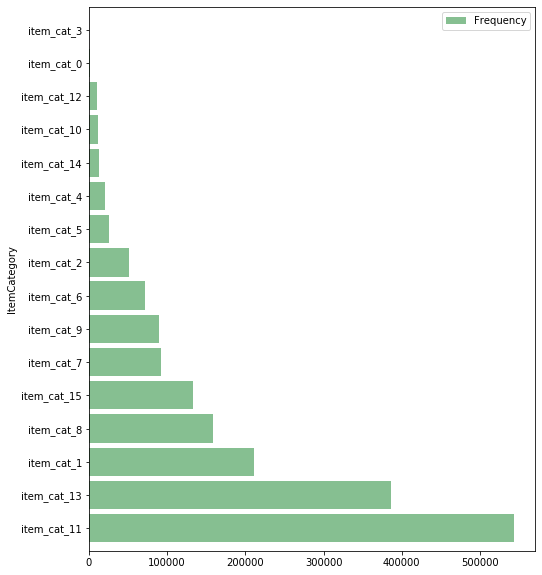

In [10]:
#frequencies of ItemCategory

fs_freq_item=sales.groupby(['ItemCategory']).size().reset_index(name='Frequency')
fs_freq_item=fs_freq_item.sort_values(by=['Frequency'], ascending =[False])
a=fs_freq_item.head(20)
ax = a.plot(kind='barh', x='ItemCategory', y='Frequency',figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

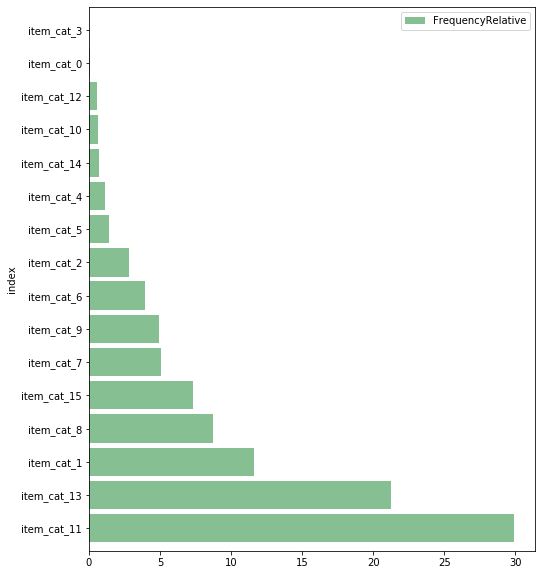

In [11]:
# relative frequencies of ItemCategoryGroup

a=sales['ItemCategory'].value_counts(True).reset_index(name='FrequencyRelative')
a['FrequencyRelative']=a['FrequencyRelative']*100
b=a.sort_values(by=['FrequencyRelative'], ascending =[False])
ab=b.head(20)
ax = ab.plot(kind='barh', x='index', y='FrequencyRelative',figsize=(8, 10), color='#86bf91', zorder=2,width=0.85)

In [12]:
#group by Order number and ItemCategory each row is order number and columns is count of items fot that order

# fs_ON = (sales.groupby(['OrderNumber', 'ItemCategory'])['Quantity'] 
#           .sum().unstack().reset_index().fillna(0) 
#           .set_index('OrderNumber')) 
# fs_ON.head(5)

ItemCategory         item_cat_0  item_cat_1  item_cat_10  item_cat_11  \
OrderNumber                                                             
order_number_10001          0.0         2.0          0.0          0.0   
order_number_100014         0.0         0.0          0.0          6.0   
order_number_100023         0.0         8.0          0.0          0.0   
order_number_100034         0.0        12.0          0.0         36.0   
order_number_100036         0.0         6.0          0.0          6.0   

ItemCategory         item_cat_12  item_cat_13  item_cat_14  item_cat_15  \
OrderNumber                                                               
order_number_10001           0.0          0.0          0.0          0.0   
order_number_100014          0.0          0.0          0.0          0.0   
order_number_100023          0.0          0.0          0.0          0.0   
order_number_100034          0.0          0.0          0.0         36.0   
order_number_100036          0.0          0.0          0.0          0.0   

ItemCategory         item_cat_2  item_cat_3  item_cat_4  item_cat_5  \
OrderNumber                                                           
order_number_10001          0.0         0.0         0.0         0.0   
order_number_100014         0.0         0.0         0.0         0.0   
order_number_100023         8.0         0.0         0.0         8.0   
order_number_100034         0.0         0.0         0.0         0.0   
order_number_100036         0.0         0.0         0.0         0.0   

ItemCategory         item_cat_6  item_cat_7  item_cat_8  item_cat_9  
OrderNumber                                                          
order_number_10001          0.0         0.0         0.0         0.0  
order_number_100014         0.0         0.0         0.0         0.0  
order_number_100023         8.0         0.0         8.0         0.0  
order_number_100034         0.0        12.0        24.0        12.0  
order_number_100036         0.0         6.0         6.0         0.0

In [545]:
# function to convert count of item in category for each order to 1 or 0
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

In [14]:
# Encoding the datasets 
# fs_ON_encoded = fs_ON.applymap(hot_encode) 
# fs_ON = fs_ON_encoded 
# fs_ON.head(5)

ItemCategory         item_cat_0  item_cat_1  item_cat_10  item_cat_11  \
OrderNumber                                                             
order_number_10001            0           1            0            0   
order_number_100014           0           0            0            1   
order_number_100023           0           1            0            0   
order_number_100034           0           1            0            1   
order_number_100036           0           1            0            1   

ItemCategory         item_cat_12  item_cat_13  item_cat_14  item_cat_15  \
OrderNumber                                                               
order_number_10001             0            0            0            0   
order_number_100014            0            0            0            0   
order_number_100023            0            0            0            0   
order_number_100034            0            0            0            1   
order_number_100036            0            0            0            0   

ItemCategory         item_cat_2  item_cat_3  item_cat_4  item_cat_5  \
OrderNumber                                                           
order_number_10001            0           0           0           0   
order_number_100014           0           0           0           0   
order_number_100023           1           0           0           1   
order_number_100034           0           0           0           0   
order_number_100036           0           0           0           0   

ItemCategory         item_cat_6  item_cat_7  item_cat_8  item_cat_9  
OrderNumber                                                          
order_number_10001            0           0           0           0  
order_number_100014           0           0           0           0  
order_number_100023           1           0           1           0  
order_number_100034           0           1           1           1  
order_number_100036           0           1           1           0

In [15]:
# create assocition with support > 0.001 using apriori algorithm
# frq_items = apriori(fs_ON, min_support = 0.1, use_colnames = True)
# frq_items.sort_values(by=['support'], ascending =[False]).head(10)

support                    itemsets
1   0.436135               (item_cat_11)
2   0.406070               (item_cat_13)
0   0.316865                (item_cat_1)
12  0.225525  (item_cat_13, item_cat_11)
7   0.216649                (item_cat_8)
9   0.196892   (item_cat_11, item_cat_1)
6   0.189838                (item_cat_7)
4   0.173283                (item_cat_2)
3   0.165213               (item_cat_15)
5   0.165161                (item_cat_6)

In [16]:
# create rules using "lift as a metric and thershold=1 "
# rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
# rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
# print("Rules amount : " , len(rules))
# rules.head(10)

Rules amount :  22


antecedents    consequents  antecedent support  \
17   (item_cat_13, item_cat_1)  (item_cat_11)            0.163834   
12                (item_cat_8)  (item_cat_11)            0.216649   
8                (item_cat_15)  (item_cat_11)            0.165213   
18   (item_cat_11, item_cat_1)  (item_cat_13)            0.196892   
1                 (item_cat_1)  (item_cat_11)            0.316865   
16  (item_cat_13, item_cat_11)   (item_cat_1)            0.225525   
6                (item_cat_13)  (item_cat_11)            0.406070   
11                (item_cat_7)  (item_cat_11)            0.189838   
15                (item_cat_8)  (item_cat_13)            0.216649   
7                (item_cat_11)  (item_cat_13)            0.436135   

    consequent support   support  confidence      lift  leverage  conviction  
17            0.436135  0.128172    0.782332  1.793785  0.056719    2.590486  
12            0.436135  0.150350    0.693981  1.591206  0.055862    1.842579  
8             0.436135  0.111019    0.671971  1.540741  0.038963    1.718949  
18            0.406070  0.128172    0.650978  1.603118  0.048220    1.701699  
1             0.436135  0.196892    0.621375  1.424731  0.058696    1.489245  
16            0.316865  0.128172    0.568329  1.793599  0.056711    1.582535  
6             0.436135  0.225525    0.555385  1.273424  0.048424    1.268208  
11            0.436135  0.103808    0.546826  1.253799  0.021013    1.244256  
15            0.406070  0.115808    0.534543  1.316380  0.027833    1.276014  
7             0.406070  0.225525    0.517099  1.273424  0.048424    1.229921

In [544]:
# fumction to plot the rules :

def draw_graph(rules, rules_to_show):
    import networkx as nx  
    G1 = nx.DiGraph()
    plt.figure(1,figsize=(15,10))
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R1', 'R2',  'R3', 'R4', 'R5','R6', 'R7', 'R8', 'R9','R10']   
    
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
    
        for a in rules.iloc[i]['antecedents']:

            G1.add_nodes_from([a])

            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 3)

        for c in rules.iloc[i]['consequents']:

            G1.add_nodes_from([c])

            G1.add_edge("R"+str(i), c, color=colors[i],  weight=3)            
  
            
    for node in G1:
        found_a_string = False

        for item in strs: 
            if node==item:
                found_a_string = True

        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green') 

        
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
 
    pos = nx.spring_layout(G1, k=16, scale=2)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights,  with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.12
    nx.draw_networkx_labels(G1, pos,font_size=20)
 
    plt.show()
#draw_graph(rules, 10)    

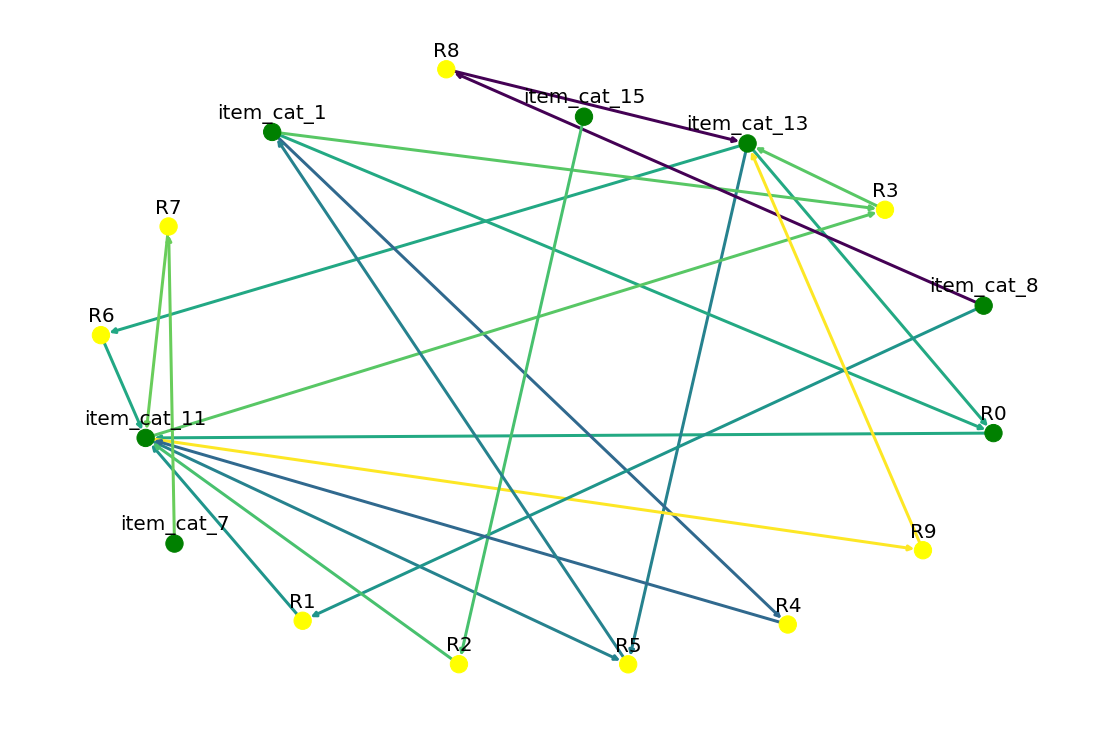

In [18]:
# Draw top 10 rules
draw_graph(rules, 10)

In [19]:
# next let find association between customers that buying the same items, so we can offer product to customer 
#with the same interset.

In [540]:
#get table with counts per ItemCategory
fs_ON2 = (sales.groupby(['CustId','ItemCategory'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('CustId')) 
fs_ON2.head(5)

ItemCategory  item_cat_0  item_cat_1  item_cat_10  item_cat_11  item_cat_12  \
CustId                                                                        
8                    0.0         1.0          0.0          0.0          0.0   
74                   0.0         0.0          0.0          0.0          0.0   
85                   0.0         1.0          0.0          0.0          0.0   
88                   0.0         0.0          0.0          0.0          0.0   
120                  0.0       672.0          0.0          0.0       1344.0   

ItemCategory  item_cat_13  item_cat_14  item_cat_15  item_cat_2  item_cat_3  \
CustId                                                                        
8                     8.0          0.0          0.0         1.0         0.0   
74                   31.0          0.0          0.0         0.0         0.0   
85                    0.0          0.0          0.0         0.0         0.0   
88                    4.0          0.0          9.0         0.0         0.0   
120                5376.0          0.0          0.0      1344.0         0.0   

ItemCategory  item_cat_4  item_cat_5  item_cat_6  item_cat_7  item_cat_8  \
CustId                                                                     
8                    0.0         0.0         0.0         4.0         0.0   
74                   0.0         0.0         0.0         0.0         0.0   
85                   0.0         0.0         0.0         0.0         0.0   
88                   0.0         0.0         0.0         0.0         0.0   
120                672.0         0.0      1400.0        55.0         0.0   

ItemCategory  item_cat_9  
CustId                    
8                    4.0  
74                   0.0  
85                   0.0  
88                   0.0  
120                  0.0

In [21]:
# Encoding the datasets 
fs_ON_cust_encoded = fs_ON2.applymap(hot_encode) 
fs_ON_cust = fs_ON_cust_encoded 
fs_ON_cust.head()

ItemCategory  item_cat_0  item_cat_1  item_cat_10  item_cat_11  item_cat_12  \
CustId                                                                        
8                      0           1            0            0            0   
74                     0           0            0            0            0   
85                     0           1            0            0            0   
88                     0           0            0            0            0   
120                    0           1            0            0            1   

ItemCategory  item_cat_13  item_cat_14  item_cat_15  item_cat_2  item_cat_3  \
CustId                                                                        
8                       1            0            0           1           0   
74                      1            0            0           0           0   
85                      0            0            0           0           0   
88                      1            0            1           0           0   
120                     1            0            0           1           0   

ItemCategory  item_cat_4  item_cat_5  item_cat_6  item_cat_7  item_cat_8  \
CustId                                                                     
8                      0           0           0           1           0   
74                     0           0           0           0           0   
85                     0           0           0           0           0   
88                     0           0           0           0           0   
120                    1           0           1           1           0   

ItemCategory  item_cat_9  
CustId                    
8                      1  
74                     0  
85                     0  
88                     0  
120                    0

In [22]:
# create assocition with support > 0.001
frq_items_cust = apriori(fs_ON_cust, min_support = 0.5, use_colnames = True)
frq_items_cust.head()

support       itemsets
0  0.630435   (item_cat_1)
1  0.695652  (item_cat_11)
2  0.734783  (item_cat_13)
3  0.582609  (item_cat_15)
4  0.639130   (item_cat_2)

In [23]:
rules_cust = association_rules(frq_items_cust, metric ="lift", min_threshold = 1) 
rules_cust = rules_cust.sort_values(['confidence', 'lift'], ascending =[False, False]) 
print(rules_cust.head(10))
rules_cust=rules_cust.head(10)

                   antecedents    consequents  antecedent support  \
55    (item_cat_8, item_cat_1)  (item_cat_11)            0.530435   
97    (item_cat_7, item_cat_2)  (item_cat_13)            0.521739   
90   (item_cat_15, item_cat_8)  (item_cat_11)            0.517391   
62    (item_cat_1, item_cat_2)  (item_cat_13)            0.517391   
80   (item_cat_11, item_cat_2)  (item_cat_13)            0.530435   
72  (item_cat_15, item_cat_13)  (item_cat_11)            0.521739   
84   (item_cat_13, item_cat_8)  (item_cat_11)            0.565217   
91  (item_cat_15, item_cat_11)   (item_cat_8)            0.530435   
73  (item_cat_15, item_cat_11)  (item_cat_13)            0.530435   
49   (item_cat_13, item_cat_1)  (item_cat_11)            0.547826   

    consequent support   support  confidence      lift  leverage  conviction  
55            0.695652  0.526087    0.991803  1.425717  0.157089   37.130435  
97            0.734783  0.508696    0.975000  1.326923  0.125331   10.608696  
90 

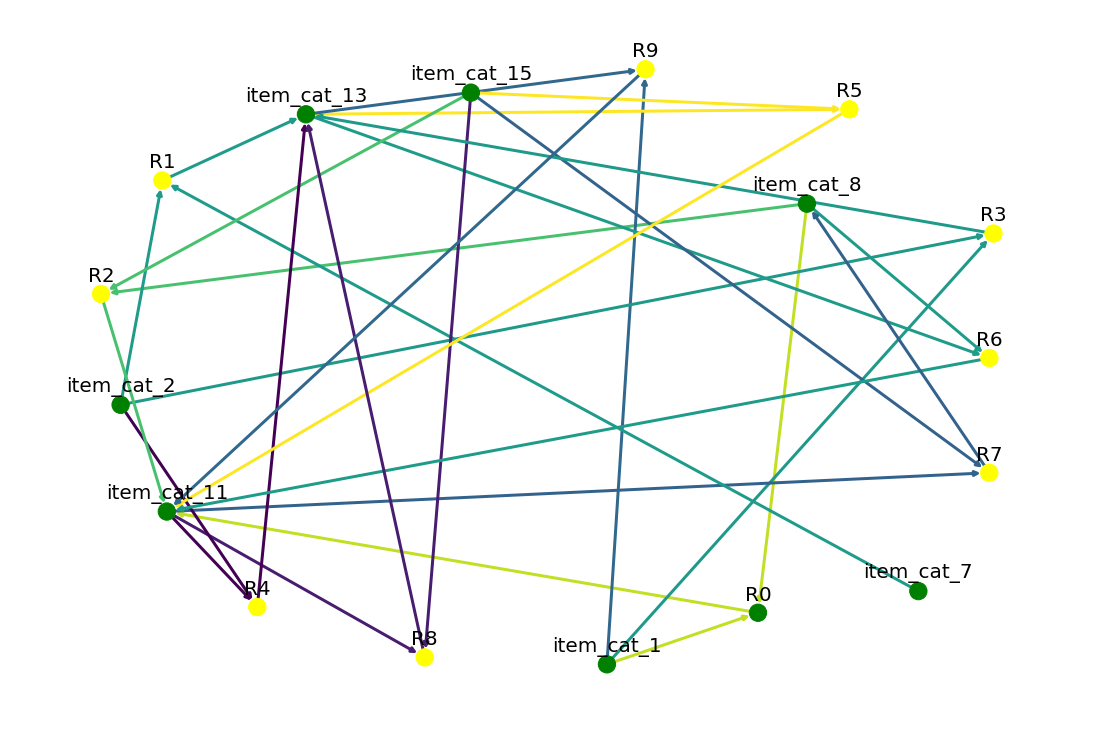

In [24]:
draw_graph(rules_cust, 10)

### Predict future purchases of various parts for customers
https://medium.com/@shubhampr31/how-to-calculate-the-customer-life-time-value-where-to-start-and-how-to-start-cc366634a4c0

RFM (recency, frequency, monetary) analysis is a marketing technique used to determine quantitatively which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary).

### EDA

In [9]:
#RFM calculation

#converting the type of Invoice Date Field from string to datetime.
sales['Date'] = pd.to_datetime(sales['Date'])

#creating YearMonth field 
sales['InvoiceYearMonth'] = sales['Date'].map(lambda date: 100*date.year + date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
sales['Revenue'] = sales['SellPrice'] * sales['Quantity']

fs_revenue = sales.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()

#Plot the data
plot_data = [
    go.Scatter(
        x=fs_revenue['InvoiceYearMonth'],
        y=fs_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [10]:
#Calculate monthly change in percantage (percentage change)

fs_revenue['MonthlyGrowth'] = fs_revenue['Revenue'].pct_change()*100

#visualization - line graph
plot_data = [
    go.Scatter(
        x=fs_revenue.query("InvoiceYearMonth < 201912")['InvoiceYearMonth'],
        y=fs_revenue.query("InvoiceYearMonth < 201912")['MonthlyGrowth'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Growth Rate'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [11]:
# count customers ID's for each month
fs_monthly_active = sales.groupby('InvoiceYearMonth')['CustId'].nunique().reset_index()

#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='CustId', rot=0, figsize=(20, 6))

plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['CustId'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Active Customers'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [12]:
# number of orders for each month

fs_monthly_active = sales.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()

#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='Quantity', rot=0, figsize=(20, 6))

plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['Quantity'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Number of Orders'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [13]:
# average revenue for each month 

fs_monthly_active = sales.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()

#ax = fs_monthly_active.plot.bar(x='InvoiceYearMonth', y='Revenue', rot=0, figsize=(20, 6))

#plot the bar chart
plot_data = [
    go.Bar(
        x=fs_monthly_active['InvoiceYearMonth'],
        y=fs_monthly_active['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Order Average'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [14]:
#create a dataframe contaning CustomerID and first purchase date

fs_min_purchase = sales.groupby('CustId').Date.min().reset_index()
fs_min_purchase.columns = ['CustId','MinPurchaseDate']
fs_min_purchase['MinPurchaseYearMonth'] = fs_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)
fs_min_purchase

#merge first purchase date column to our main dataframe
sales = pd.merge(sales, fs_min_purchase, on='CustId')
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0 2014-01-02  order_number_194969               80         1  1009.33081   
1 2014-01-02  order_number_105429              180         1    55.99986   
2 2014-01-02  order_number_105429              180         1  1847.99538   
3 2014-01-02  order_number_105429              180         1   459.99885   
4 2014-01-02  order_number_105429              180         1    33.33325   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
2  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
3  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
4  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   

   ...                       Industry IndustryGroup       Plant   PlantType  \
0  ...  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION  Chesapeake  Unassigned   
1  ...  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION  Chesapeake  Unassigned   
2  ...  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION  Chesapeake  Unassigned   
3  ...  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION  Chesapeake  Unassigned   
4  ...  WHOLESALE TRADE-DURABLE GOODS  DISTRIBUTION  Chesapeake  Unassigned   

      PlantPlatform            Market InvoiceYearMonth     Revenue  \
0  plant_platform_1  General Industry           201401  1009.33081   
1  plant_platform_1  General Industry           201401    55.99986   
2  plant_platform_1  General Industry           201401  1847.99538   
3  plant_platform_1  General Industry           201401   459.99885   
4  plant_platform_1  General Industry           201401    33.33325   

  MinPurchaseDate MinPurchaseYearMonth  
0      2014-01-02               201401  
1      2014-01-02               201401  
2      2014-01-02               201401  
3      2014-01-02               201401  
4      2014-01-02               201401  

[5 rows x 34 columns]

In [15]:
#create a column called User Type and assign New or Existing 
# we want to compare if the orders were made by a new cusotmer or old customers

sales['UserType'] = 'New'
sales.loc[sales['InvoiceYearMonth']>sales['MinPurchaseYearMonth'],'UserType'] = 'Existing'
sales.head(5)

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0 2014-01-02  order_number_194969               80         1  1009.33081   
1 2014-01-02  order_number_105429              180         1    55.99986   
2 2014-01-02  order_number_105429              180         1  1847.99538   
3 2014-01-02  order_number_105429              180         1   459.99885   
4 2014-01-02  order_number_105429              180         1    33.33325   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
2  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
3  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
4  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   

   ... IndustryGroup       Plant   PlantType     PlantPlatform  \
0  ...  DISTRIBUTION  Chesapeake  Unassigned  plant_platform_1   
1  ...  DISTRIBUTION  Chesapeake  Unassigned  plant_platform_1   
2  ...  DISTRIBUTION  Chesapeake  Unassigned  plant_platform_1   
3  ...  DISTRIBUTION  Chesapeake  Unassigned  plant_platform_1   
4  ...  DISTRIBUTION  Chesapeake  Unassigned  plant_platform_1   

             Market InvoiceYearMonth     Revenue  MinPurchaseDate  \
0  General Industry           201401  1009.33081       2014-01-02   
1  General Industry           201401    55.99986       2014-01-02   
2  General Industry           201401  1847.99538       2014-01-02   
3  General Industry           201401   459.99885       2014-01-02   
4  General Industry           201401    33.33325       2014-01-02   

  MinPurchaseYearMonth UserType  
0               201401      New  
1               201401      New  
2               201401      New  
3               201401      New  
4               201401      New  

[5 rows x 35 columns]

In [16]:
#calculate the Revenue per month for each user type (new vs exist)

fs_user_type_revenue = sales.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()
fs_user_type_revenue.head(5)

InvoiceYearMonth  UserType       Revenue
0            201401       New  2.008806e+07
1            201402  Existing  2.529167e+07
2            201402       New  6.707103e+05
3            201403  Existing  2.757499e+07
4            201403       New  1.426036e+05

In [17]:
# plot the data
plot_data = [
    go.Scatter(
        x=fs_user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'],
        y=fs_user_type_revenue.query("UserType == 'Existing'")['Revenue'],
        name = 'Existing'
    ),
    go.Scatter(
        x=fs_user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'],
        y=fs_user_type_revenue.query("UserType == 'New'")['Revenue'],
        name = 'New'
   )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [18]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)

fs_user_ratio = sales.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustId'].nunique()/sales.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustId'].nunique() 
fs_user_ratio = fs_user_ratio.reset_index()
fs_user_ratio = fs_user_ratio.dropna()

#  <1 - existing more

#plot the result

plot_data = [
    go.Bar(
        x=fs_user_ratio.query("InvoiceYearMonth>201501 and InvoiceYearMonth<201912")['InvoiceYearMonth'],
        y=fs_user_ratio.query("InvoiceYearMonth>201501 and InvoiceYearMonth<201912")['CustId'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [19]:
#Retention calculation :
#Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total
#create retention matrix with crosstab
#identify which users are active by looking at their revenue per month
fs_user_purchase = sales.groupby(['CustId','InvoiceYearMonth'])['Revenue'].sum().reset_index()
fs_user_purchase

fs_retention = pd.crosstab(fs_user_purchase['CustId'], fs_user_purchase['InvoiceYearMonth']).reset_index()

fs_retention.head(5)

InvoiceYearMonth  CustId  201401  201402  201403  201404  201405  201406  \
0                      8       0       0       0       0       0       0   
1                     74       0       0       0       0       0       0   
2                     85       0       0       0       0       0       1   
3                     88       0       0       0       0       0       0   
4                    120       0       0       0       0       0       0   

InvoiceYearMonth  201407  201408  201409  ...  201808  201809  201810  201811  \
0                      0       0       0  ...       0       0       0       0   
1                      0       0       0  ...       0       0       0       0   
2                      0       0       0  ...       0       0       0       0   
3                      0       0       0  ...       0       0       0       0   
4                      0       0       0  ...       0       0       0       0   

InvoiceYearMonth  201812  201901  201902  201903  201904  201905  
0                      0       0       0       1       0       0  
1                      0       0       0       0       0       0  
2                      0       0       0       0       0       0  
3                      0       0       0       0       0       0  
4                      0       0       0       0       0       0  

[5 rows x 66 columns]

In [20]:
#create an array of dictionary which keeps Retained & Total User count for each month
#customer bought in 2 consequencs months

months = fs_retention.columns[2:]
retention_array = []

for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = fs_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = fs_retention[(fs_retention[selected_month]>0) & (fs_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
fs_retention = pd.DataFrame(retention_array)
fs_retention['RetentionRate'] = fs_retention['RetainedUserCount']/fs_retention['TotalUserCount']

#plot the retention rate graph
plot_data = [
    go.Scatter(
        x=fs_retention.query("InvoiceYearMonth<201912")['InvoiceYearMonth'],
        y=fs_retention.query("InvoiceYearMonth<201912")['RetentionRate'],
        name="organic"
    )
    
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly Retention Rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [21]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function
#convert retention 0,1 to rate
#getting 1 customer ID with purchase month

fs_retention = pd.crosstab(fs_user_purchase['CustId'], fs_user_purchase['InvoiceYearMonth']).reset_index()
#new column names
new_column_names = [ 'm_' + str(column) for column in fs_retention.columns]
fs_retention.columns = new_column_names

#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = fs_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(fs_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
        
    retention_array.append(retention_data)
    
fs_retention = pd.DataFrame(retention_array)
fs_retention.index = months

#showing new cohort based retention table
fs_retention.head(10)

TotalUserCount  201402  201403  201404  201405  201406  \
InvoiceYearMonth                                                           
201402                        61     1.0     0.8    0.74    0.74    0.70   
201403                        63     NaN     1.0    0.83    0.79    0.73   
201404                        68     NaN     NaN    1.00    0.81    0.71   
201405                        66     NaN     NaN     NaN    1.00    0.74   
201406                        63     NaN     NaN     NaN     NaN    1.00   
201407                        56     NaN     NaN     NaN     NaN     NaN   
201408                        63     NaN     NaN     NaN     NaN     NaN   
201409                        57     NaN     NaN     NaN     NaN     NaN   
201410                        66     NaN     NaN     NaN     NaN     NaN   
201411                        55     NaN     NaN     NaN     NaN     NaN   

                  201407  201408  201409  201410  ...  201808  201809  201810  \
InvoiceYearMonth                                  ...                           
201402              0.67    0.67    0.62    0.62  ...    0.39    0.39    0.39   
201403              0.70    0.68    0.62    0.62  ...    0.38    0.38    0.38   
201404              0.68    0.66    0.59    0.57  ...    0.35    0.35    0.35   
201405              0.70    0.68    0.61    0.59  ...    0.36    0.36    0.36   
201406              0.78    0.73    0.63    0.62  ...    0.38    0.38    0.38   
201407              1.00    0.89    0.77    0.75  ...    0.43    0.43    0.43   
201408               NaN    1.00    0.79    0.76  ...    0.38    0.38    0.38   
201409               NaN     NaN    1.00    0.86  ...    0.42    0.42    0.42   
201410               NaN     NaN     NaN    1.00  ...    0.36    0.36    0.36   
201411               NaN     NaN     NaN     NaN  ...    0.45    0.45    0.45   

                  201811  201812  201901  201902  201903  201904  201905  
InvoiceYearMonth                                                          
201402              0.39    0.39    0.39    0.39    0.38    0.38    0.34  
201403              0.38    0.38    0.38    0.38    0.37    0.37    0.33  
201404              0.35    0.35    0.35    0.35    0.34    0.34    0.31  
201405              0.36    0.36    0.36    0.36    0.35    0.35    0.32  
201406              0.38    0.38    0.38    0.38    0.37    0.37    0.33  
201407              0.43    0.43    0.43    0.43    0.41    0.41    0.38  
201408              0.38    0.38    0.38    0.38    0.37    0.37    0.33  
201409              0.42    0.42    0.42    0.42    0.40    0.40    0.37  
201410              0.36    0.36    0.36    0.36    0.35    0.35    0.32  
201411              0.45    0.45    0.45    0.45    0.44    0.44    0.40  

[10 rows x 65 columns]

RFM (recency, frequency, monetary) analysis is a marketing technique used to determine quantitatively which customers are the best ones by examining how recently a customer has purchased (recency), how often they purchase (frequency), and how much the customer spends (monetary).

In [22]:
#get the last purchase date for each customer

fs_max_purchase = sales.groupby('CustId').Date.max().reset_index()
fs_max_purchase.columns = ['CustId','MaxPurchaseDate']
fs_max_purchase.head()

CustId MaxPurchaseDate
0       8      2019-03-27
1      74      2017-07-21
2      85      2014-06-04
3      88      2017-04-27
4     120      2018-04-18

In [23]:
#data frame with customer ID
sales_cust = pd.DataFrame(sales['CustId'].unique())
sales_cust.columns = ['CustId']
print(len(sales_cust))
sales_cust.head(10)

230


CustId
0     535
1     876
2     879
3    4279
4    1584
5    2768
6    2000
7    2110
8    2053
9    1130

In [24]:
#Last invoice from the whole dataset 
#calculate difference between last purcahse and each last invose per customer
fs_max_purchase['Recency'] = (fs_max_purchase['MaxPurchaseDate'].max() - fs_max_purchase['MaxPurchaseDate']).dt.days

In [25]:
fs_max_purchase_sort=fs_max_purchase.sort_values(by=['Recency'], ascending =[False])
print(len(fs_max_purchase_sort))
fs_max_purchase_sort.head(10)

230


CustId MaxPurchaseDate  Recency
217    4124      2014-01-15     1938
74     1387      2014-01-20     1933
139    2605      2014-02-05     1917
73     1369      2014-03-18     1876
204    3858      2014-03-21     1873
54      958      2014-03-28     1866
216    4105      2014-04-11     1852
194    3730      2014-05-16     1817
2        85      2014-06-04     1798
37      643      2014-06-16     1786

In [26]:
#merge this dataframe to our new user dataframe
fs_cust = pd.merge(sales_cust, fs_max_purchase[['CustId','Recency']], on='CustId')
print(len(fs_cust))
a=fs_max_purchase.sort_values(by=['Recency'], ascending =[False])
a.tail(150)

230


CustId MaxPurchaseDate  Recency
100    1870      2017-07-18      658
13      229      2017-07-21      655
1        74      2017-07-21      655
161    3052      2017-08-02      643
39      656      2017-08-25      620
..      ...             ...      ...
176    3408      2019-05-07        0
122    2282      2019-05-07        0
65     1130      2019-05-07        0
64     1113      2019-05-07        0
82     1604      2019-05-07        0

[150 rows x 3 columns]

In [27]:
#plot a recency histogram
# recency by blocks, 
plot_data = [
    go.Histogram(
        x=fs_cust['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [28]:
# lets try to remove the data with recency leas than 7 days

In [29]:
# fs_cust_temp=fs_cust
# fs_cust_temp=fs_cust_temp
# fs_cust_temp.drop(fs_cust_temp.loc[fs_cust_temp['Recency']<=7].index, inplace=True)
# fs_cust_temp

# #plot a recency histogram
# # recency by blocks, 
# plot_data = [
#     go.Histogram(
#         x=fs_cust['Recency']
#     )
# ]

# plot_layout = go.Layout(
#         title='Recency'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# pyoff.iplot(fig)

In [30]:
#fs_cust_temp.Recency.describe()

In [31]:
# let create cluster based on Recency

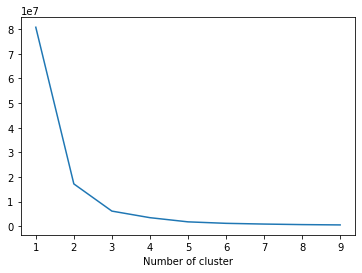

In [32]:
# criteria - Sum of squared distances of samples to their closest cluster center.
sse={}
fs_recency = fs_cust[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(fs_recency)
    fs_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [33]:
#optimum number is 3
n_clusters=3

In [34]:
#build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Recency']])
fs_cust['RecencyCluster'] = kmeans.predict(fs_cust[['Recency']])
fs_cust.head()

CustId  Recency  RecencyCluster
0     535      350               0
1     876        7               0
2     879        0               0
3    4279        0               0
4    1584        1               0

In [35]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

fs_cust = order_cluster('RecencyCluster', 'Recency',fs_cust,False)
fs_cust.head()

CustId  Recency  RecencyCluster
0     535      350               2
1     876        7               2
2     879        0               2
3    4279        0               2
4    1584        1               2

In [36]:
fs_cust.groupby('RecencyCluster')['Recency'].describe()

count         mean         std     min     25%     50%  \
RecencyCluster                                                           
0                33.0  1644.606061  195.923604  1275.0  1484.0  1677.0   
1                57.0   884.754386  207.634920   509.0   721.0   841.0   
2               140.0    94.842857  134.042100     0.0     1.0    26.5   

                   75%     max  
RecencyCluster                  
0               1798.0  1938.0  
1               1096.0  1236.0  
2                118.0   476.0

In [37]:
# next adding Frequency

In [38]:
# Frequency clustering

#get order counts for each user and create a dataframe with it
fs_frequency = sales.groupby('CustId').Date.count().reset_index()
fs_frequency.columns = ['CustId','Frequency']

In [39]:
#add this data to our main dataframe
fs_cust = pd.merge(fs_cust, fs_frequency, on='CustId')
fs_cust.head(5)
fs_cust.sort_values(by=['Frequency'], ascending =[False])
len(fs_cust)

230

In [40]:
# delete frequency =1
fs_cust_temp_freq=fs_cust
fs_cust_temp_freq.drop(fs_cust_temp_freq.loc[fs_cust_temp_freq['Frequency']==1].index, inplace=True)
fs_cust_temp_freq.tail()

CustId  Recency  RecencyCluster  Frequency
222    3547     1397               0         81
224     125     1677               0          2
225    2168     1708               0         64
226    2089     1693               0         36
227    1881     1688               0          4

In [41]:
fs_cust=fs_cust_temp_freq
len(fs_cust)

202

In [42]:
#k-means
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Frequency']])
fs_cust['FrequencyCluster'] = kmeans.predict(fs_cust[['Frequency']])

#order the frequency cluster
fs_cust = order_cluster('FrequencyCluster', 'Frequency',fs_cust,True)

#see details of each cluster
fs_cust.groupby('FrequencyCluster')['Frequency'].describe()

count           mean           std       min        25%  \
FrequencyCluster                                                            
0                 179.0    2153.307263   4649.219684       2.0      16.00   
1                  21.0   48937.047619  17204.744440   26927.0   37424.00   
2                   2.0  202298.500000  21980.414293  186756.0  194527.25   

                       50%        75%       max  
FrequencyCluster                                 
0                    131.0    1098.50   24619.0  
1                  45426.0   57032.00  101065.0  
2                 202298.5  210069.75  217841.0

In [43]:
#dropping customer, think outliers
# sales.drop(sales.loc[sales['CustId']=='cust_id_576'].index, inplace=True)
# sales.drop(sales.loc[sales['CustId']=='cust_id_1653'].index, inplace=True)
# sales.shape

In [44]:
fs_cust_sort=fs_cust.sort_values(by=['Frequency'], ascending =[False])
fs_cust_sort.head
len(fs_cust_sort)
fs_cust_sort.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster
179     876        7               2     217841                 2
180    4279        0               2     186756                 2
195    4201        0               2     101065                 1
197    3163        0               2      73934                 1
181     879        0               2      65277                 1

In [45]:
# one customer has 211573 orders, that drives the cluster to 1 data point.
# lets try to delete it cust_id_576

In [46]:
# fs_cust_test=fs_cust
# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_3827'].index, inplace=True)
# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_1697'].index, inplace=True)
# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_2585'].index, inplace=True)


# #fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_576'].index, inplace=True)
# fs_cust_test

# #k-means
# kmeans = KMeans(n_clusters)
# kmeans.fit(fs_cust_test[['Frequency']])
# fs_cust_test['FrequencyCluster'] = kmeans.predict(fs_cust_test[['Frequency']])

# #order the frequency cluster
# fs_cust_test = order_cluster('FrequencyCluster', 'Frequency',fs_cust_test,True)

# #see details of each cluster
# fs_cust_test.groupby('FrequencyCluster')['Frequency'].describe()

In [47]:
# # looks better w/o cust_id_576 
# # Ill proceed w/o it
# fs_cust=fs_cust_test

In [48]:
# Revenue Clustering

#calculate revenue for each customer
fs_revenue = sales.groupby('CustId').Revenue.sum().reset_index()

#merge it with our main dataframe
fs_cust = pd.merge(fs_cust, fs_revenue, on='CustId')
fs_cust.head(5)

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue
0     535      350               2      13306                 0  9.649215e+06
1    2768        1               2      24619                 0  2.446567e+07
2    2110        4               2      12055                 0  1.163927e+07
3    1848        5               2       4218                 0  5.774035e+06
4     325        1               2      19999                 0  1.700047e+07

In [49]:
fs_cust.sort_values(by=['Revenue'], ascending =[False])

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster  \
190    1621      145               2      37162                 1   
180    4279        0               2     186756                 2   
179     876        7               2     217841                 2   
196    2462        1               2      60147                 1   
197    3163        0               2      73934                 1   
..      ...      ...             ...        ...               ...   
178    1881     1688               0          4                 0   
100    2516        7               2          4                 0   
105    3826      265               2          8                 0   
69     3740      461               2          2                 0   
132    3560     1181               1          4                 0   

          Revenue  
190  1.161112e+08  
180  8.613326e+07  
179  8.493859e+07  
196  7.816350e+07  
197  7.439997e+07  
..            ...  
178  4.799988e+02  
100  3.999990e+02  
105  3.146659e+02  
69   1.866662e+02  
132  1.653329e+02  

[202 rows x 6 columns]

In [50]:
#apply clustering
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Revenue']])
fs_cust['RevenueCluster'] = kmeans.predict(fs_cust[['Revenue']])


#order the cluster numbers
fs_cust = order_cluster('RevenueCluster', 'Revenue',fs_cust,True)
fs_cust
#show details of the dataframe
fs_cust.groupby('RevenueCluster')['Revenue'].describe()

count          mean           std           min           25%  \
RevenueCluster                                                                  
0               174.0  1.445619e+06  2.831780e+06  1.653329e+02  1.558763e+04   
1                18.0  2.643962e+07  8.644786e+06  1.437129e+07  1.950807e+07   
2                10.0  7.477528e+07  1.833906e+07  5.371216e+07  6.095605e+07   

                         50%           75%           max  
RevenueCluster                                            
0               1.238530e+05  9.409763e+05  1.163927e+07  
1               2.500771e+07  3.035037e+07  4.121114e+07  
2               7.344263e+07  8.324482e+07  1.161112e+08

In [51]:
#calculate overall score and use mean() to see details

fs_cust['OverallScore'] = fs_cust['RecencyCluster'] + fs_cust['FrequencyCluster'] + fs_cust['RevenueCluster']
fs_cust.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

Recency      Frequency       Revenue
OverallScore                                          
0             1604.952381     164.666667  1.774394e+05
1              878.367347     234.265306  3.318005e+05
2              115.778846    2773.432692  2.226473e+06
3               12.600000   16413.600000  2.669587e+07
4               10.846154   40986.461538  2.634107e+07
5               18.375000   61856.750000  7.208512e+07
6                3.500000  202298.500000  8.553593e+07

In [52]:
# Let's create a clustering based on score 

fs_cust['Segment'] = 'Low-Value'
fs_cust.loc[fs_cust['OverallScore']>=2,'Segment'] = 'Mid-Value' 
fs_cust.loc[fs_cust['OverallScore']>=4,'Segment'] = 'High-Value' 


In [53]:
fs_cust.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
0     535      350               2      13306                 0  9.649215e+06   
1    2110        4               2      12055                 0  1.163927e+07   
2    1848        5               2       4218                 0  5.774035e+06   
3     276        1               2       6223                 0  5.908336e+06   
4    1066       13               2        209                 0  2.616767e+05   

   RevenueCluster  OverallScore    Segment  
0               0             2  Mid-Value  
1               0             2  Mid-Value  
2               0             2  Mid-Value  
3               0             2  Mid-Value  
4               0             2  Mid-Value

In [54]:
#see details of each cluster
fs_cust.groupby('Segment')['Segment'].describe()

count unique         top freq
Segment                                 
High-Value    23      1  High-Value   23
Low-Value     70      1   Low-Value   70
Mid-Value    109      1   Mid-Value  109

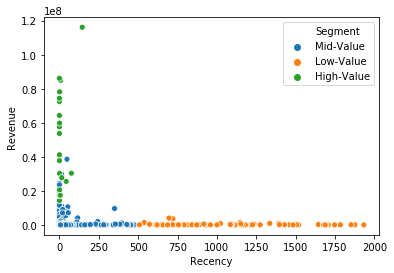

In [55]:
sns.scatterplot(x="Recency", y="Revenue", data=fs_cust, hue="Segment")

# High Value: Improve Retention
# Mid Value: Improve Retention + Increase Frequency¶
# Low Value: Increase Frequency

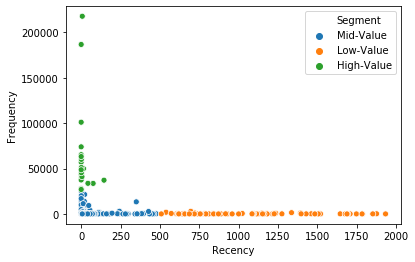

In [56]:
sns.scatterplot(x="Recency", y="Frequency", data=fs_cust, hue="Segment")

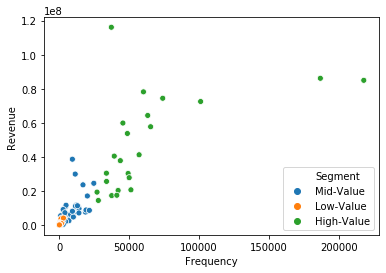

In [57]:
sns.scatterplot(x="Frequency", y="Revenue", data=fs_cust, hue="Segment")

In [58]:
fs_cust.groupby('Segment')['Segment'].describe()

count unique         top freq
Segment                                 
High-Value    23      1  High-Value   23
Low-Value     70      1   Low-Value   70
Mid-Value    109      1   Mid-Value  109

# High Value: Improve Retention
# Mid Value: Improve Retention + Increase Frequency
# Low Value: Increase Frequency

# Predicitng the net profit using data 2014-2016, and verifying using 2017-2019

# No need for project

In marketing, customer lifetime value (CLV or often CLTV), lifetime customer value (LCV), or life-time value (LTV) is a prediction of the net profit attributed to the entire future relationship with a customer.


In [59]:
# model build on 2014-2017
# predict 2017-2019

fs_calc = sales[(sales.Date >= date(2014,1,1)) & (sales.Date < date(2017,1,1))].reset_index(drop=True)
fs_next = sales[(sales.Date >= date(2017,1,1)) & (sales.Date < date(2019,12,31))].reset_index(drop=True)

print(len(fs_calc))
print(len(fs_next))

1023834
793911


In [60]:
#create fs_calc for assigning clustering
# same action as above just for training data set

fs_cust = pd.DataFrame(fs_calc['CustId'].unique())
fs_cust.columns = ['CustId']

#calculate recency score
fs_max_purchase = fs_calc.groupby('CustId').Date.max().reset_index()
fs_max_purchase.columns = ['CustId','MaxPurchaseDate']
fs_max_purchase['Recency'] = (fs_max_purchase['MaxPurchaseDate'].max() - fs_max_purchase['MaxPurchaseDate']).dt.days
fs_cust = pd.merge(fs_cust, fs_max_purchase[['CustId','Recency']], on='CustId')

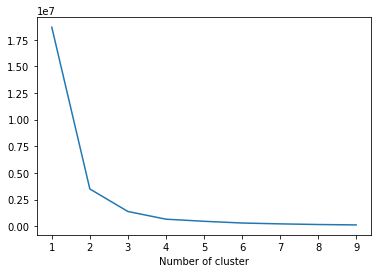

In [61]:
# criteria - Sum of squared distances of samples to their closest cluster center.
sse={}
fs_recency = fs_cust[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=2000).fit(fs_recency)
    fs_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [62]:
#  optimum cluster based on recency
n_clusters=3

In [63]:
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Recency']])
fs_cust['RecencyCluster'] = kmeans.predict(fs_cust[['Recency']])

fs_cust = order_cluster('RecencyCluster', 'Recency',fs_cust,False)
fs_cust['RecencyCluster'].value_counts()
fs_cust.groupby('RecencyCluster')['Recency'].describe()

count        mean         std    min    25%    50%    75%  \
RecencyCluster                                                              
0                35.0  845.114286  149.025614  603.0  710.5  830.0  976.5   
1                39.0  349.128205  109.823586  192.0  258.0  323.0  413.0   
2                96.0   31.375000   42.111194    0.0    2.0   12.5   49.0   

                   max  
RecencyCluster          
0               1080.0  
1                571.0  
2                165.0

In [64]:
fs_max_purchase.sort_values(by=['Recency'], ascending =[False])

CustId MaxPurchaseDate  Recency
159    4124      2014-01-15     1080
52     1387      2014-01-20     1075
161    4187      2014-01-27     1068
105    2605      2014-02-05     1059
51     1369      2014-03-18     1018
..      ...             ...      ...
60     1610      2016-12-30        0
122    2984      2016-12-30        0
21      535      2016-12-30        0
58     1586      2016-12-30        0
110    2768      2016-12-30        0

[170 rows x 3 columns]

In [65]:
len(fs_cust)

170

In [66]:
#calcuate frequency score
fs_frequency = fs_calc.groupby('CustId').Date.count().reset_index()
fs_frequency.columns = ['CustId','Frequency']
fs_cust = pd.merge(fs_cust, fs_frequency, on='CustId')

In [67]:
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Frequency']])
fs_cust['FrequencyCluster'] = kmeans.predict(fs_cust[['Frequency']])

fs_cust = order_cluster('FrequencyCluster', 'Frequency',fs_cust,True)
fs_cust['FrequencyCluster'].value_counts()

0    144
1     23
2      3
Name: FrequencyCluster, dtype: int64

In [68]:
fs_cust_sort=fs_cust.sort_values(by=['Frequency'], ascending =[False])
fs_cust_sort.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster
144     876        3               2     120471                 2
145    4279        3               2     108393                 2
146    4201        9               2      66887                 2
155    1700        1               2      43016                 1
163    3163        0               2      39220                 1

In [69]:
#fs_cust_test=fs_cust
#fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_576'].index, inplace=True)

# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_876'].index, inplace=True)
# fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_4279'].index, inplace=True)
#fs_cust_test.drop(fs_cust_test.loc[fs_cust_test['CustId']=='cust_id_2585'].index, inplace=True)

In [70]:
# kmeans = KMeans(n_clusters)
# kmeans.fit(fs_cust_test[['Frequency']])
# fs_cust_test['FrequencyCluster'] = kmeans.predict(fs_cust_test[['Frequency']])

# fs_cust_test = order_cluster('FrequencyCluster', 'Frequency',fs_cust_test,True)
# fs_cust_test['FrequencyCluster'].value_counts()

In [71]:
# # lets use without 576
# #fs_cust=fs_cust_test

# #calcuate revenue score
fs_calc['Revenue'] = fs_calc['SellPrice'] * fs_calc['Quantity']
fs_revenue = fs_calc.groupby('CustId').Revenue.sum().reset_index()
fs_cust = pd.merge(fs_cust, fs_revenue, on='CustId')
kmeans = KMeans(n_clusters)
kmeans.fit(fs_cust[['Revenue']])
fs_cust['RevenueCluster'] = kmeans.predict(fs_cust[['Revenue']])
fs_cust = order_cluster('RevenueCluster', 'Revenue',fs_cust,True)
fs_cust.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
0     535        0               2      10654                 0  7.579433e+06   
1    2110        1               2       7318                 0  6.488310e+06   
2    1848       50               2       2288                 0  2.013588e+06   
3     325        2               2      10415                 0  1.086783e+07   
4     276        8               2       3761                 0  3.832066e+06   

   RevenueCluster  
0               0  
1               0  
2               0  
3               0  
4               0

In [72]:
#fs_cust_test.groupby('FrequencyCluster')['Frequency'].describe()

In [73]:
#overall scoring
fs_cust['OverallScore'] = fs_cust['RecencyCluster'] + fs_cust['FrequencyCluster'] + fs_cust['RevenueCluster']
fs_cust['Segment'] = 'Low-Value'
fs_cust.loc[fs_cust['OverallScore']>=2,'Segment'] = 'Mid-Value' 
fs_cust.loc[fs_cust['OverallScore']>=4,'Segment'] = 'High-Value' 

In [74]:
fs_cust['OverallScore'].value_counts()

2    70
1    39
0    35
4    15
3     7
5     4
Name: OverallScore, dtype: int64

In [75]:
fs_cust.groupby('Segment')['Segment'].describe()

count unique         top freq
Segment                                 
High-Value    19      1  High-Value   19
Low-Value     74      1   Low-Value   74
Mid-Value     77      1   Mid-Value   77

In [76]:
#calculate revenue and create a new dataframe for it from modeling years 2017-2019
# using next 2 years calcualte the revenue
fs_next['Revenue'] = fs_next['SellPrice'] * fs_next['Quantity']
fs_cust_next = fs_next.groupby('CustId')['Revenue'].sum().reset_index()
fs_cust_next.columns = ['CustId','next_Revenue']
fs_cust_next.head(5)

CustId  next_Revenue
0       8   48639.87840
1      74     206.66615
2      88   10135.97466
3     120    4653.32170
4     129   62415.84396

In [77]:
# merge with initial dataframe

fs_merge = pd.merge(fs_cust, fs_cust_next, on='CustId', how='left')
fs_merge = fs_merge.fillna(0)
fs_merge.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
0     535        0               2      10654                 0  7.579433e+06   
1    2110        1               2       7318                 0  6.488310e+06   
2    1848       50               2       2288                 0  2.013588e+06   
3     325        2               2      10415                 0  1.086783e+07   
4     276        8               2       3761                 0  3.832066e+06   

   RevenueCluster  OverallScore    Segment  next_Revenue  
0               0             2  Mid-Value  2.069781e+06  
1               0             2  Mid-Value  5.150964e+06  
2               0             2  Mid-Value  3.760447e+06  
3               0             2  Mid-Value  6.132642e+06  
4               0             2  Mid-Value  2.076269e+06

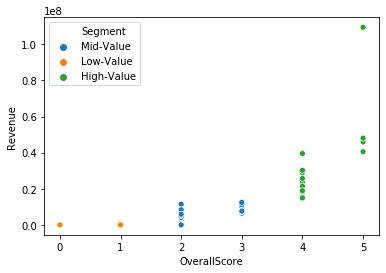

In [78]:
sns.scatterplot(x="OverallScore", y="Revenue", data=fs_merge, hue="Segment")

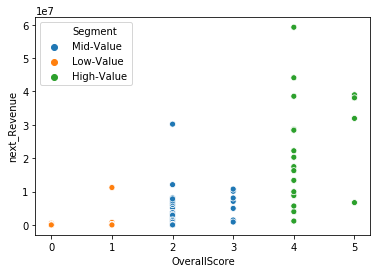

In [79]:
sns.scatterplot(x="OverallScore", y="next_Revenue", data=fs_merge, hue="Segment")

In [80]:
fs_merge.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
0     535        0               2      10654                 0  7.579433e+06   
1    2110        1               2       7318                 0  6.488310e+06   
2    1848       50               2       2288                 0  2.013588e+06   
3     325        2               2      10415                 0  1.086783e+07   
4     276        8               2       3761                 0  3.832066e+06   

   RevenueCluster  OverallScore    Segment  next_Revenue  
0               0             2  Mid-Value  2.069781e+06  
1               0             2  Mid-Value  5.150964e+06  
2               0             2  Mid-Value  3.760447e+06  
3               0             2  Mid-Value  6.132642e+06  
4               0             2  Mid-Value  2.076269e+06

In [81]:
#remove outliers
#fs_merge = fs_merge[fs_merge['next_Revenue']<fs_merge['next_Revenue'].quantile(0.95)]
# drop next revenue equal to 0
fs_merge.drop(fs_merge.loc[fs_merge['next_Revenue']==0].index, inplace=True)

#creating 3 clusters of next revenue
#LTV cluster - life time customer value


kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(fs_merge[['next_Revenue']])
fs_merge['LTVCluster'] = kmeans.predict(fs_merge[['next_Revenue']])

#order cluster number based on LTV
fs_merge = order_cluster('LTVCluster', 'next_Revenue',fs_merge,True)

#creatinga new cluster dataframe
fs_cluster = fs_merge.copy()

#see details of the clusters
fs_cluster.groupby('LTVCluster')['next_Revenue'].describe()

count          mean           std           min           25%  \
LTVCluster                                                                  
0            80.0  6.976524e+05  1.189438e+06  6.266651e+01  5.920985e+03   
1            22.0  1.042881e+07  4.737017e+06  5.672820e+06  7.098508e+06   
2             9.0  3.757653e+07  9.787450e+06  2.838667e+07  3.020897e+07   

                     50%           75%           max  
LTVCluster                                            
0           9.306110e+04  8.546449e+05  5.150964e+06  
1           8.455864e+06  1.185272e+07  2.222680e+07  
2           3.808717e+07  3.901095e+07  5.925283e+07

In [82]:
fs_cluster.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
0     535        0               2      10654                 0  7.579433e+06   
1    2110        1               2       7318                 0  6.488310e+06   
2    1848       50               2       2288                 0  2.013588e+06   
3     276        8               2       3761                 0  3.832066e+06   
4    3603       49               2       1090                 0  3.342220e+06   

   RevenueCluster  OverallScore    Segment  next_Revenue  LTVCluster  
0               0             2  Mid-Value  2.069781e+06           0  
1               0             2  Mid-Value  5.150964e+06           0  
2               0             2  Mid-Value  3.760447e+06           0  
3               0             2  Mid-Value  2.076269e+06           0  
4               0             2  Mid-Value  2.498087e+05           0

In [83]:
# import re
# fs_cluster['CustId']=fs_cluster['CustId'].str.extract('(\d+)')
#fs_cluster['CustId']=pd.to_numeric(fs_cluster.CustId)

In [84]:
fs_cluster.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
0     535        0               2      10654                 0  7.579433e+06   
1    2110        1               2       7318                 0  6.488310e+06   
2    1848       50               2       2288                 0  2.013588e+06   
3     276        8               2       3761                 0  3.832066e+06   
4    3603       49               2       1090                 0  3.342220e+06   

   RevenueCluster  OverallScore    Segment  next_Revenue  LTVCluster  
0               0             2  Mid-Value  2.069781e+06           0  
1               0             2  Mid-Value  5.150964e+06           0  
2               0             2  Mid-Value  3.760447e+06           0  
3               0             2  Mid-Value  2.076269e+06           0  
4               0             2  Mid-Value  2.498087e+05           0

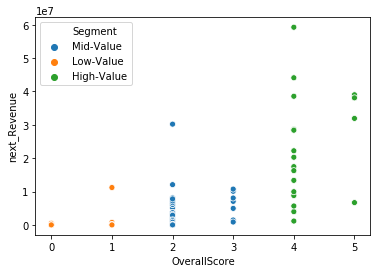

In [85]:
sns.scatterplot(x="OverallScore", y="next_Revenue", data=fs_cluster, hue="Segment")

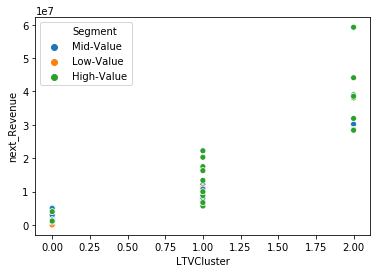

In [86]:
sns.scatterplot(x="LTVCluster", y="next_Revenue", data=fs_cluster, hue="Segment")

In [87]:
fs_cluster.groupby('LTVCluster')['LTVCluster'].describe()

count  mean  std  min  25%  50%  75%  max
LTVCluster                                           
0            80.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1            22.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
2             9.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0

In [88]:
fs_cluster.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
0     535        0               2      10654                 0  7.579433e+06   
1    2110        1               2       7318                 0  6.488310e+06   
2    1848       50               2       2288                 0  2.013588e+06   
3     276        8               2       3761                 0  3.832066e+06   
4    3603       49               2       1090                 0  3.342220e+06   

   RevenueCluster  OverallScore    Segment  next_Revenue  LTVCluster  
0               0             2  Mid-Value  2.069781e+06           0  
1               0             2  Mid-Value  5.150964e+06           0  
2               0             2  Mid-Value  3.760447e+06           0  
3               0             2  Mid-Value  2.076269e+06           0  
4               0             2  Mid-Value  2.498087e+05           0

In [89]:
#convert categorical columns to numerical, preparation to run model
fs_class = pd.get_dummies(fs_cluster)
#fs_class_matrix=fs_cluster

#calculate and show correlations
corr_matrix = fs_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
next_Revenue          0.905336
FrequencyCluster      0.710086
Segment_High-Value    0.692901
Frequency             0.668959
OverallScore          0.666988
RevenueCluster        0.663672
Revenue               0.627049
RecencyCluster        0.257063
CustId                0.124707
Segment_Low-Value    -0.267122
Recency              -0.299006
Segment_Mid-Value    -0.310011
Name: LTVCluster, dtype: float64

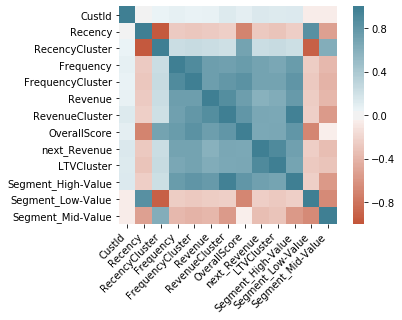

In [90]:
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [91]:
fs_class.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
0     535        0               2      10654                 0  7.579433e+06   
1    2110        1               2       7318                 0  6.488310e+06   
2    1848       50               2       2288                 0  2.013588e+06   
3     276        8               2       3761                 0  3.832066e+06   
4    3603       49               2       1090                 0  3.342220e+06   

   RevenueCluster  OverallScore  next_Revenue  LTVCluster  Segment_High-Value  \
0               0             2  2.069781e+06           0                   0   
1               0             2  5.150964e+06           0                   0   
2               0             2  3.760447e+06           0                   0   
3               0             2  2.076269e+06           0                   0   
4               0             2  2.498087e+05           0                   0   

   Segment_Low-Value  Segment_Mid-Value  
0                  0                  1  
1                  0                  1  
2                  0                  1  
3                  0                  1  
4                  0                  1

In [92]:
#create X and y, X will be feature set and y is the label - LTV
X = fs_class.drop(['LTVCluster','next_Revenue'],axis=1)
y = fs_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(y_train.value_counts())

(88, 11) (88,)
(23, 11) (23,)
0    62
1    18
2     8
Name: LTVCluster, dtype: int64


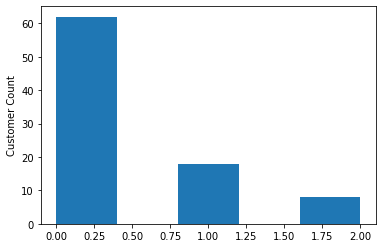

In [94]:
plt.hist(y_train, bins=5)
plt.ylabel('Customer Count')
plt.show()

In [95]:
fs_class.head()

CustId  Recency  RecencyCluster  Frequency  FrequencyCluster       Revenue  \
0     535        0               2      10654                 0  7.579433e+06   
1    2110        1               2       7318                 0  6.488310e+06   
2    1848       50               2       2288                 0  2.013588e+06   
3     276        8               2       3761                 0  3.832066e+06   
4    3603       49               2       1090                 0  3.342220e+06   

   RevenueCluster  OverallScore  next_Revenue  LTVCluster  Segment_High-Value  \
0               0             2  2.069781e+06           0                   0   
1               0             2  5.150964e+06           0                   0   
2               0             2  3.760447e+06           0                   0   
3               0             2  2.076269e+06           0                   0   
4               0             2  2.498087e+05           0                   0   

   Segment_Low-Value  Segment_Mid-Value  
0                  0                  1  
1                  0                  1  
2                  0                  1  
3                  0                  1  
4                  0                  1

In [96]:
# XGBoost Multiclassification Model
#https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1,random_state=42).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test, y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy=accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" % (accuracy *100))

Accuracy of XGB classifier on training set: 0.94
Accuracy of XGB classifier on test set: 0.83
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.50      0.75      0.60         4
           2       1.00      1.00      1.00         1

    accuracy                           0.83        23
   macro avg       0.81      0.86      0.83        23
weighted avg       0.86      0.83      0.84        23

Accuracy: 82.61%


In [97]:
# test inblancing different technique

In [98]:
y_pred.shape

(23,)

In [99]:
uniqueValues, occurCount = np.unique(y_pred, return_counts=True)
uniqueValues
occurCount

array([16,  6,  1], dtype=int64)

Confusion matrix:
 [[15  3  0]
 [ 1  3  0]
 [ 0  0  1]]


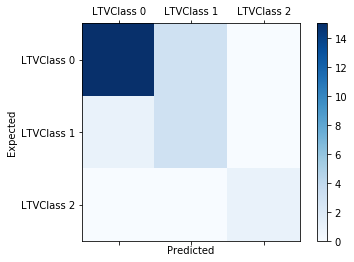

In [100]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['LTVClass 0', 'LTVClass 1', 'LTVClass 2']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [101]:
smote=SMOTE('minority')

xsm,ysm=smote.fit_sample(X_train,y_train)
xsm,ysm=smote.fit_sample(xsm,ysm)
print(xsm.shape,ysm.shape)

(186, 11) (186,)


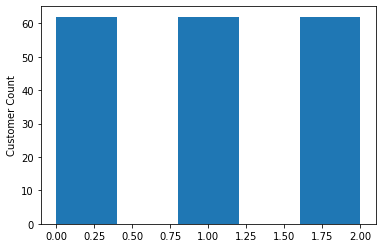

In [102]:
plt.hist(ysm, bins=5)
plt.ylabel('Customer Count')
plt.show()

In [103]:
X_test=X_test.as_matrix()
y_test=y_test.as_matrix()

In [104]:
# XGBoost Multiclassification Model
#https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1,random_state=42).fit(xsm, ysm)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(xsm, ysm)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test, y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy=accuracy_score(y_test,y_pred)
print("Accuracy: %.2f%%" % (accuracy *100))

Accuracy of XGB classifier on training set: 0.98
Accuracy of XGB classifier on test set: 0.78
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       0.50      0.75      0.60         4
           2       0.50      1.00      0.67         1

    accuracy                           0.78        23
   macro avg       0.64      0.84      0.71        23
weighted avg       0.84      0.78      0.80        23

Accuracy: 78.26%


Confusion matrix:
 [[14  3  1]
 [ 1  3  0]
 [ 0  0  1]]


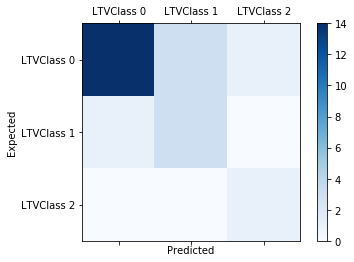

In [105]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['LTVClass 0', 'LTVClass 1', 'LTVClass 2']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [106]:
#   end of test

In [107]:
# smote=SMOTE('minority')

# xsm,ysm=smote.fit_sample(X_train,y_train)
# xsm,ysm=smote.fit_sample(xsm,ysm)
# print(xsm.shape,ysm.shape)

In [108]:
fs_class_revenue=fs_class

In [109]:
# print(X_test.shape,y_test.shape)
# #print(ysm.value_counts())
# uniqueValues, occurCount = np.unique(ysm, return_counts=True)
# print(uniqueValues,occurCount)

In [110]:
# xsm1,ysm1=smote.fit_sample(xsm,ysm)
# print(xsm1.shape,ysm1.shape)

In [111]:
# # XGBoost Multiclassification Model

# ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

# print('Accuracy of XGB classifier on training set: {:.2f}'
#        .format(ltv_xgb_model.score(X_train, y_train)))
# print('Accuracy of XGB classifier on test set: {:.2f}'
#        .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

# y_pred = ltv_xgb_model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [112]:
# X_test=X_test.as_matrix()
# y_test=y_test.as_matrix()

In [113]:
# # XGBoost Multiclassification Model
# #https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

# ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(xsm, ysm)

# print('Accuracy of XGB classifier on training set: {:.2f}'
#        .format(ltv_xgb_model.score(xsm, ysm)))
# print('Accuracy of XGB classifier on test set: {:.2f}'
#        .format(ltv_xgb_model.score(X_test, y_test)))

# y_pred = ltv_xgb_model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [114]:
# # XGBoost Multiclassification Model
# # Predict next revenue

# ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(xsm, ysm)

# print('Accuracy of XGB classifier on training set: {:.2f}'
#        .format(ltv_xgb_model.score(xsm, ysm)))
# print('Accuracy of XGB classifier on test set: {:.2f}'
#        .format(ltv_xgb_model.score(X_test, y_test)))

# y_pred = ltv_xgb_model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [115]:
# from imblearn.combine import SMOTETomek

# smt = SMOTETomek(ratio='auto')
# X_smt, y_smt = smt.fit_sample(X_train, y_train)

# np.size(y_smt,0)
# unique_elements, counts_elements = np.unique(y_smt, return_counts=True)
# print("Frequency of unique values of the said array:")
# print(np.asarray((unique_elements, counts_elements)))

In [116]:
# # XGBoost Multiclassification Model

# ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.01,objective= 'multi:softprob',n_jobs=-1).fit(X_smt, y_smt)

# print('Accuracy of XGB classifier on training set: {:.2f}'
#        .format(ltv_xgb_model.score(X_smt, y_smt)))
# print('Accuracy of XGB classifier on test set: {:.2f}'
#        .format(ltv_xgb_model.score(X_test, y_test)))

# y_pred = ltv_xgb_model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [117]:
# from sklearn.metrics import confusion_matrix
# from matplotlib import pyplot as plt

# conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
# print('Confusion matrix:\n', conf_mat)

# labels = ['Class 0', 'Class 1', 'Class 2']
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# plt.xlabel('Predicted')
# plt.ylabel('Expected')
# plt.show()



# Predicitng the purchase using data 2014-2016, and verifying using 2017-2019

# Need for project



In [292]:
fs_cust_copy=fs_cust

In [293]:
# same data division for years
fs_prev = sales[(sales.Date >= date(2014,1,1)) & (sales.Date < date(2017,1,1))].reset_index(drop=True)
fs_next = sales[(sales.Date >= date(2017,1,1)) & (sales.Date < date(2019,12,31))].reset_index(drop=True)
fs_user = pd.DataFrame(fs_prev['CustId'].unique())
fs_user.columns = ['CustId']
fs_user.head()

CustId
0     535
1     876
2     879
3    4279
4    1584

In [294]:
#create a dataframe with customer id and first purchase date in fs_next

fs_next_first_purchase = fs_next.groupby('CustId').Date.min().reset_index()
fs_next_first_purchase.columns = ['CustId','MinPurchaseDate']
fs_next_first_purchase.head()

CustId MinPurchaseDate
0       8      2019-03-15
1      74      2017-07-21
2      88      2017-03-01
3     120      2018-03-08
4     129      2018-09-05

In [295]:
#create a dataframe with customer id and last purchase date in fs_next
fs_last_purchase = fs_prev.groupby('CustId').Date.max().reset_index()
fs_last_purchase.columns = ['CustId','MaxPurchaseDate']

#merge two dataframes
fs_purchase_dates = pd.merge(fs_last_purchase,fs_next_first_purchase,on='CustId',how='left')
fs_purchase_dates.head()

CustId MaxPurchaseDate MinPurchaseDate
0      85      2014-06-04             NaT
1     120      2014-10-04      2018-03-08
2     125      2014-10-03             NaT
3     153      2016-11-30      2017-07-25
4     178      2016-12-19      2017-01-10

In [296]:
#calculate the time difference in days:
fs_purchase_dates['NextPurchaseDay'] = (fs_purchase_dates['MinPurchaseDate'] - fs_purchase_dates['MaxPurchaseDate']).dt.days

#merge with fs_user 
fs_user = pd.merge(fs_user, fs_purchase_dates[['CustId','NextPurchaseDay']],on='CustId',how='left')
fs_user.head()

CustId  NextPurchaseDay
0     535              6.0
1     876              7.0
2     879              6.0
3    4279              8.0
4    1584              6.0

In [297]:
#fill NA values with 999, meaning only one purchase in prev dataset
fs_user = fs_user.fillna(999)
fs_user.head()

CustId  NextPurchaseDay
0     535              6.0
1     876              7.0
2     879              6.0
3    4279              8.0
4    1584              6.0

In [298]:
#create a dataframe with CustomerID and Invoice Date
fs_day_order = fs_prev[['CustId','Date']]

#convert Invoice Datetime to day
fs_day_order['InvoiceDay'] = fs_prev['Date'].dt.date
fs_day_order = fs_day_order.sort_values(['CustId','Date'])
len(fs_day_order)
fs_day_order.head()

CustId       Date  InvoiceDay
1023299      85 2014-06-04  2014-06-04
1019819     120 2014-10-04  2014-10-04
1019820     120 2014-10-04  2014-10-04
1019821     120 2014-10-04  2014-10-04
1019822     120 2014-10-04  2014-10-04

In [299]:
#drop duplicates
fs_day_order = fs_day_order.drop_duplicates(subset=['CustId','InvoiceDay'],keep='first')
fs_day_order.head(10)
len(fs_day_order)

13694

In [300]:
#shifting last 3 purchase dates, create purchase distances

fs_day_order['PrevInvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(1)
fs_day_order['Shift2InvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(2)
fs_day_order['Shift3InvoiceDate'] = fs_day_order.groupby('CustId')['InvoiceDay'].shift(3)

In [301]:
# find differences between purchases
fs_day_order['DayDiff'] = (fs_day_order['InvoiceDay'] - fs_day_order['PrevInvoiceDate']).dt.days
fs_day_order['DayDiff2'] = (fs_day_order['InvoiceDay'] - fs_day_order['Shift2InvoiceDate']).dt.days
fs_day_order['DayDiff3'] = (fs_day_order['InvoiceDay'] - fs_day_order['Shift3InvoiceDate']).dt.days

In [302]:
# find mean and std
fs_day_diff = fs_day_order.groupby('CustId').agg({'DayDiff': ['mean','std']}).reset_index()
fs_day_diff.columns = ['CustId', 'DayDiffMean','DayDiffStd']
fs_day_diff.head()

CustId  DayDiffMean  DayDiffStd
0      85          NaN         NaN
1     120          NaN         NaN
2     125    36.000000         NaN
3     153    36.481481   30.113082
4     178     5.004651    4.162020

In [303]:
# drop duplicates
fs_day_order_last = fs_day_order.drop_duplicates(subset=['CustId'],keep='last')
fs_day_order_last = fs_day_order_last.dropna()
fs_day_order_last.head()

CustId       Date  InvoiceDay PrevInvoiceDate Shift2InvoiceDate  \
1013639     153 2016-11-30  2016-11-30      2016-10-27        2016-10-06   
932172      178 2016-12-19  2016-12-19      2016-12-16        2016-12-15   
1005438     221 2015-04-16  2015-04-16      2015-02-05        2015-01-23   
589838      228 2016-12-28  2016-12-28      2016-12-27        2016-12-21   
859531      229 2016-12-20  2016-12-20      2016-12-16        2016-12-06   

        Shift3InvoiceDate  DayDiff  DayDiff2  DayDiff3  
1013639        2016-09-02     34.0      55.0      89.0  
932172         2016-11-23      3.0       4.0      26.0  
1005438        2015-01-20     70.0      83.0      86.0  
589838         2016-12-20      1.0       7.0       8.0  
859531         2016-12-05      4.0      14.0      15.0

In [304]:
fs_day_order_last = pd.merge(fs_day_order_last, fs_day_diff, on='CustId')
fs_day_order_last.head()

CustId       Date  InvoiceDay PrevInvoiceDate Shift2InvoiceDate  \
0     153 2016-11-30  2016-11-30      2016-10-27        2016-10-06   
1     178 2016-12-19  2016-12-19      2016-12-16        2016-12-15   
2     221 2015-04-16  2015-04-16      2015-02-05        2015-01-23   
3     228 2016-12-28  2016-12-28      2016-12-27        2016-12-21   
4     229 2016-12-20  2016-12-20      2016-12-16        2016-12-06   

  Shift3InvoiceDate  DayDiff  DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0        2016-09-02     34.0      55.0      89.0    36.481481   30.113082  
1        2016-11-23      3.0       4.0      26.0     5.004651    4.162020  
2        2015-01-20     70.0      83.0      86.0    50.285714   63.978419  
3        2016-12-20      1.0       7.0       8.0     7.104895   13.615812  
4        2016-12-05      4.0      14.0      15.0    18.877551   28.781239

In [305]:
fs_cust_copy = pd.merge(fs_user, fs_cust_copy, on='CustId')
fs_cust_copy.head()

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0     535              6.0        0               2      10654   
1     876              7.0        3               2     120471   
2     879              6.0        1               2      34794   
3    4279              8.0        3               2     108393   
4    1584              6.0        2               2      29907   

   FrequencyCluster       Revenue  RevenueCluster  OverallScore     Segment  
0                 0  7.579433e+06               0             2   Mid-Value  
1                 2  4.592764e+07               1             5  High-Value  
2                 1  2.902659e+07               1             4  High-Value  
3                 2  4.804609e+07               1             5  High-Value  
4                 1  2.141297e+07               1             4  High-Value

In [306]:
#merge to datasets

fs_user2 = pd.merge(fs_cust_copy, fs_day_order_last[['CustId','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustId')
#create fs_class as a copy of fs_user before applying get_dummies
fs_user2.head()

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0     535              6.0        0               2      10654   
1     876              7.0        3               2     120471   
2     879              6.0        1               2      34794   
3    4279              8.0        3               2     108393   
4    1584              6.0        2               2      29907   

   FrequencyCluster       Revenue  RevenueCluster  OverallScore     Segment  \
0                 0  7.579433e+06               0             2   Mid-Value   
1                 2  4.592764e+07               1             5  High-Value   
2                 1  2.902659e+07               1             4  High-Value   
3                 2  4.804609e+07               1             5  High-Value   
4                 1  2.141297e+07               1             4  High-Value   

   DayDiff  DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  
0      2.0       8.0      11.0     5.844920    5.899017  
1      1.0       6.0       8.0     2.233607    1.571936  
2      2.0       7.0       8.0     2.723192    2.130888  
3      5.0       6.0       7.0     1.656535    1.225290  
4      1.0       5.0       6.0     2.549065    1.743485

In [307]:
fs_class = fs_user2.copy()
fs_class['CustId']=pd.to_numeric(fs_class.CustId)
fs_class = pd.get_dummies(fs_class)
fs_class.head()

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0     535              6.0        0               2      10654   
1     876              7.0        3               2     120471   
2     879              6.0        1               2      34794   
3    4279              8.0        3               2     108393   
4    1584              6.0        2               2      29907   

   FrequencyCluster       Revenue  RevenueCluster  OverallScore  DayDiff  \
0                 0  7.579433e+06               0             2      2.0   
1                 2  4.592764e+07               1             5      1.0   
2                 1  2.902659e+07               1             4      2.0   
3                 2  4.804609e+07               1             5      5.0   
4                 1  2.141297e+07               1             4      1.0   

   DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  Segment_High-Value  \
0       8.0      11.0     5.844920    5.899017                   0   
1       6.0       8.0     2.233607    1.571936                   1   
2       7.0       8.0     2.723192    2.130888                   1   
3       6.0       7.0     1.656535    1.225290                   1   
4       5.0       6.0     2.549065    1.743485                   1   

   Segment_Low-Value  Segment_Mid-Value  
0                  0                  1  
1                  0                  0  
2                  0                  0  
3                  0                  0  
4                  0                  0

In [308]:
fs_cust_copy.shape

(170, 10)

In [309]:
fs_class=fs_class.sort_values(by=['NextPurchaseDay'], ascending =[False])
fs_class.head()

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
83    1634           1043.0      694               0         12   
96    1635            999.0      417               1        110   
87     492            999.0      603               0        150   
56    3472            999.0      890               0          8   
65    3816            999.0      290               1        855   

    FrequencyCluster       Revenue  RevenueCluster  OverallScore  DayDiff  \
83                 0  6.549984e+04               0             0     37.0   
96                 0  2.854660e+04               0             1     62.0   
87                 0  6.425584e+04               0             0     71.0   
56                 0  7.886647e+03               0             0     78.0   
65                 0  1.557157e+06               0             1    245.0   

    DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  Segment_High-Value  \
83      51.0     135.0    45.000000   35.679126                   0   
96     126.0     355.0   126.000000   79.745428                   0   
87     192.0     416.0   138.666667   78.014956                   0   
56      92.0     188.0    49.750000   43.652988                   0   
65     363.0     586.0    31.840000   65.758827                   0   

    Segment_Low-Value  Segment_Mid-Value  
83                  1                  0  
96                  1                  0  
87                  1                  0  
56                  1                  0  
65                  1                  0

In [310]:
# delete 999, meaning 1 purchase

fs_class.drop(fs_class.loc[fs_class['NextPurchaseDay']==999].index, inplace=True)

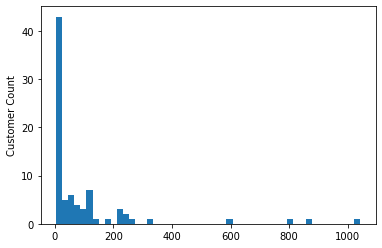

In [311]:

plt.hist(fs_class.NextPurchaseDay, bins=50)
plt.ylabel('Customer Count')
plt.show()

In [312]:
fs_class.shape

(81, 17)

In [313]:
fs_class.NextPurchaseDay.describe()

count      81.000000
mean       95.382716
std       186.576363
min         4.000000
25%         7.000000
50%        21.000000
75%       104.000000
max      1043.000000
Name: NextPurchaseDay, dtype: float64

In [314]:

#classification of the data

fs_class['NextPurchaseDayRange'] = 2
fs_class.loc[fs_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
fs_class.loc[fs_class.NextPurchaseDay>100,'NextPurchaseDayRange'] = 0

In [315]:
fs_class.groupby('NextPurchaseDayRange')['NextPurchaseDay'].describe()

count        mean         std    min    25%    50%  \
NextPurchaseDayRange                                                       
0                      21.0  300.571429  278.904925  104.0  125.0  218.0   
1                      21.0   50.380952   24.013488   21.0   27.0   53.0   
2                      39.0    9.128205    4.396048    4.0    6.0    7.0   

                        75%     max  
NextPurchaseDayRange                 
0                     262.0  1043.0  
1                      69.0    93.0  
2                      13.0    20.0

In [319]:
fs_class.head()

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
83    1634           1043.0      694               0         12   
62     221            876.0      624               0        100   
94    1737            795.0      207               1         21   
88     646            604.0       31               2        236   
68     542            334.0      307               1       1775   

    FrequencyCluster       Revenue  RevenueCluster  OverallScore  DayDiff  \
83                 0  6.549984e+04               0             0     37.0   
62                 0  1.399717e+05               0             0     70.0   
94                 0  9.103977e+03               0             1     12.0   
88                 0  5.191520e+05               0             2    533.0   
68                 0  1.340777e+06               0             1     73.0   

    DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  Segment_High-Value  \
83      51.0     135.0    45.000000   35.679126                   0   
62      83.0      86.0    50.285714   63.978419                   0   
94     278.0     760.0   154.000000  214.890670                   0   
88     536.0     587.0    55.888889  123.461301                   0   
68      79.0     201.0    15.560000   35.254851                   0   

    Segment_Low-Value  Segment_Mid-Value  NextPurchaseDayRange  
83                  1                  0                     0  
62                  1                  0                     0  
94                  1                  0                     0  
88                  0                  1                     0  
68                  1                  0                     0

In [320]:
sns.set(font_scale=1)

In [389]:
#chart  only
fs_class2=fs_class
fs_class2['PurchaseRange'] = '>100 days'
fs_class2.loc[fs_class2['NextPurchaseDayRange']==1,'PurchaseRange'] = '[20..100] days' 
fs_class2.loc[fs_class2['NextPurchaseDayRange']==2,'PurchaseRange'] = '<20 days' 
fs_class2.head()

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
83    1634           1043.0      694               0         12   
62     221            876.0      624               0        100   
94    1737            795.0      207               1         21   
88     646            604.0       31               2        236   
68     542            334.0      307               1       1775   

    FrequencyCluster       Revenue  RevenueCluster  OverallScore  DayDiff  \
83                 0  6.549984e+04               0             0     37.0   
62                 0  1.399717e+05               0             0     70.0   
94                 0  9.103977e+03               0             1     12.0   
88                 0  5.191520e+05               0             2    533.0   
68                 0  1.340777e+06               0             1     73.0   

    DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  Segment_High-Value  \
83      51.0     135.0    45.000000   35.679126                   0   
62      83.0      86.0    50.285714   63.978419                   0   
94     278.0     760.0   154.000000  214.890670                   0   
88     536.0     587.0    55.888889  123.461301                   0   
68      79.0     201.0    15.560000   35.254851                   0   

    Segment_Low-Value  Segment_Mid-Value  NextPurchaseDayRange PurchaseRange  
83                  1                  0                     0     >100 days  
62                  1                  0                     0     >100 days  
94                  1                  0                     0     >100 days  
88                  0                  1                     0     >100 days  
68                  1                  0                     0     >100 days

In [538]:
#chart maling only

plt.figure(figsize = (10,5))

sns.set_context("notebook", font_scale=1.1)
#sns.set_style("ticks")

ax=sns.stripplot(x="OverallScore", y="NextPurchaseDay", data=fs_class2, hue="PurchaseRange",s=10) 

# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     horizontalalignment='right',
# )
# ax.set_yticklabels(
#     ax.get_yticklabels(),
#     #rotation=0,
#     #horizontalalignment='right',
#     #tick.label.set_fontsize(14)
#     #fontsize = 16    
# );
#plt.legend('PurchaseRange', prop={'size': 10})
plt.xticks( fontsize = 15)
plt.yticks( fontsize = 15) 
plt.ylabel('Next_Purchase (Days)', fontsize=16)
plt.xlabel('RFM Score', fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title


ValueError: Could not interpret input 'PurchaseRange'

<Figure size 720x360 with 0 Axes>

In [391]:
fs_class2.groupby('PurchaseRange')['NextPurchaseDay'].describe()

count        mean         std    min    25%    50%    75%  \
PurchaseRange                                                               
<20 days         39.0    9.128205    4.396048    4.0    6.0    7.0   13.0   
>100 days        21.0  300.571429  278.904925  104.0  125.0  218.0  262.0   
[20..100] days   21.0   50.380952   24.013488   21.0   27.0   53.0   69.0   

                   max  
PurchaseRange           
<20 days          20.0  
>100 days       1043.0  
[20..100] days    93.0

In [392]:
#remove for model
fs_class2=fs_class2.drop(['PurchaseRange'], axis=1)
fs_class2.head()

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
83    1634           1043.0      694               0         12   
62     221            876.0      624               0        100   
94    1737            795.0      207               1         21   
88     646            604.0       31               2        236   
68     542            334.0      307               1       1775   

    FrequencyCluster       Revenue  RevenueCluster  OverallScore  DayDiff  \
83                 0  6.549984e+04               0             0     37.0   
62                 0  1.399717e+05               0             0     70.0   
94                 0  9.103977e+03               0             1     12.0   
88                 0  5.191520e+05               0             2    533.0   
68                 0  1.340777e+06               0             1     73.0   

    DayDiff2  DayDiff3  DayDiffMean  DayDiffStd  Segment_High-Value  \
83      51.0     135.0    45.000000   35.679126                   0   
62      83.0      86.0    50.285714   63.978419                   0   
94     278.0     760.0   154.000000  214.890670                   0   
88     536.0     587.0    55.888889  123.461301                   0   
68      79.0     201.0    15.560000   35.254851                   0   

    Segment_Low-Value  Segment_Mid-Value  NextPurchaseDayRange  
83                  1                  0                     0  
62                  1                  0                     0  
94                  1                  0                     0  
88                  0                  1                     0  
68                  1                  0                     0

In [393]:
#convert categorical columns to numerical, preparation to run model
#fs_class = pd.get_dummies(fs_cluster)
#fs_class_matrix=fs_cluster

#calculate and show correlations
corr_matrix = fs_class.corr()
corr_matrix['NextPurchaseDayRange'].sort_values(ascending=False)

NextPurchaseDayRange    1.000000
OverallScore            0.551968
FrequencyCluster        0.472825
Segment_High-Value      0.447745
Revenue                 0.439143
RevenueCluster          0.438543
Frequency               0.424694
RecencyCluster          0.354602
CustId                  0.116160
Segment_Mid-Value      -0.216777
Segment_Low-Value      -0.377031
DayDiff                -0.437583
Recency                -0.496034
DayDiffStd             -0.541609
DayDiff2               -0.601726
DayDiffMean            -0.607789
NextPurchaseDay        -0.614417
DayDiff3               -0.650382
Name: NextPurchaseDayRange, dtype: float64

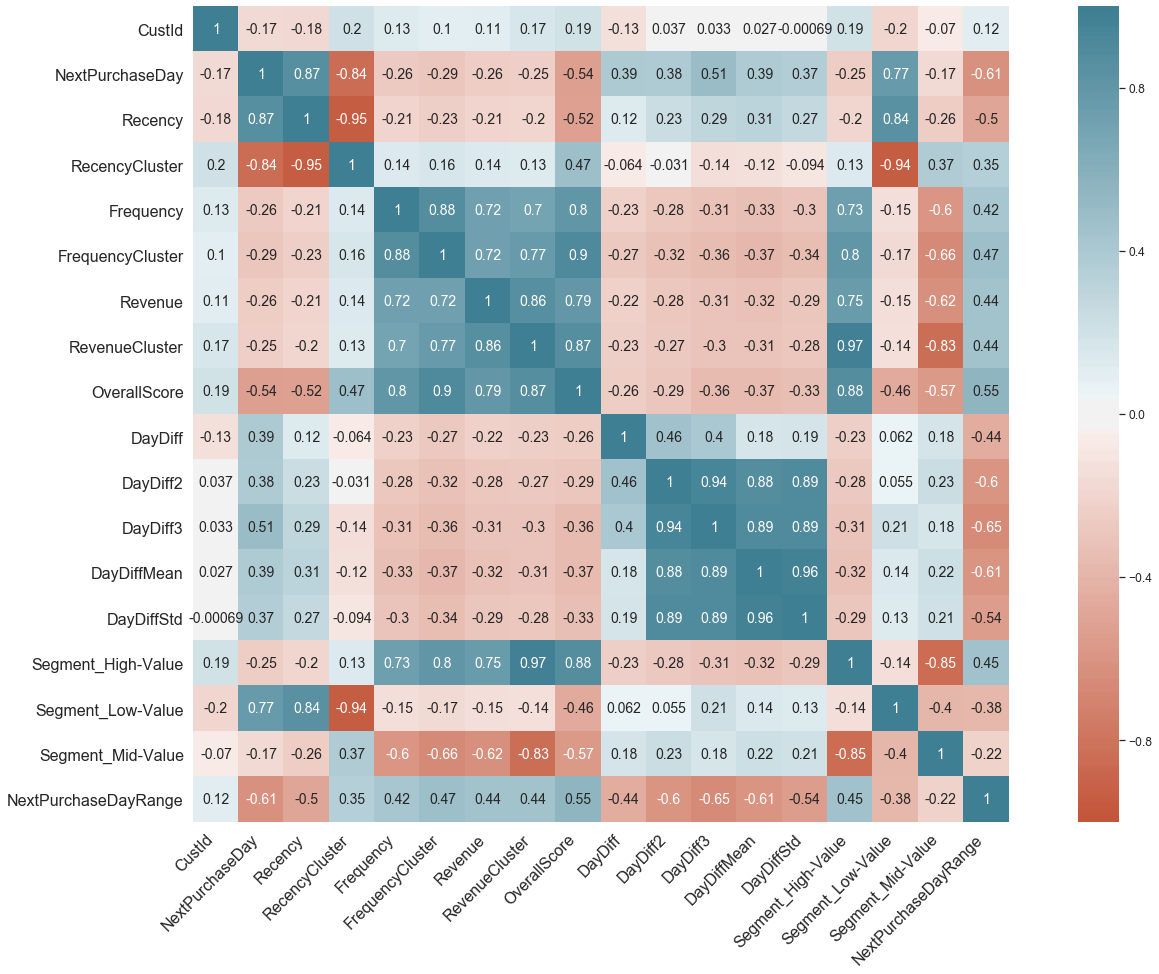

In [394]:
plt.figure(figsize = (25,15))
ax = sns.heatmap(
    corr_matrix,annot=True, annot_kws={"fontsize":14},
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    #tick.label.set_fontsize(14)
    fontsize = 16)
ax.set_yticklabels(
    ax.get_xticklabels(),
    rotation=0,
    horizontalalignment='right',
    #tick.label.set_fontsize(14)
    fontsize = 16    
);
sns.set(font_scale=4)

In [395]:
sns.set(font_scale=1)

In [396]:
#train & test split
from sklearn.model_selection import StratifiedShuffleSplit
#fs_class = fs_class.drop('NextPurchaseDay',axis=1)
#sratifield
X, y = fs_class2.drop('NextPurchaseDayRange',axis=1), fs_class.NextPurchaseDayRange
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.6, random_state=42)

In [397]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# X=X.as_matrix()
# y=y.as_matrix()

# sss.split(X, y)
# for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train2, X_test2 = X[train_index], X[test_index]
#     y_train2, y_test2 = y[train_index], y[test_index]

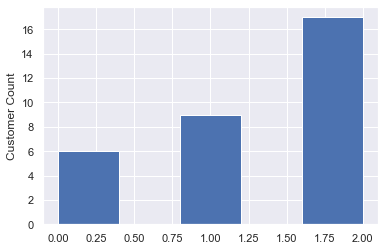

In [398]:
plt.hist(y_train1, bins=5)
plt.ylabel('Customer Count')
plt.show()

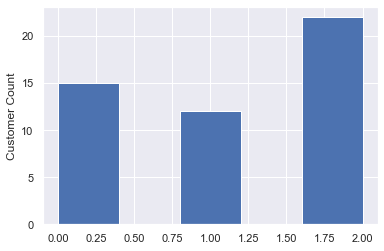

In [399]:
plt.hist(y_test1, bins=5)
plt.ylabel('Customer Count')
plt.show()

In [400]:
fs_class2.shape

(81, 18)

In [462]:
#create an array of models, evaluation based on f1 score
models = []
models.append(("LR",LogisticRegression(random_state=42)))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier(random_state=42)))
models.append(("SVC",SVC(random_state=42)))
#models.append(("Dtree",DecisionTreeClassifier(random_state=42)))
#models.append(("XGB",xgb.XGBClassifier(random_state=42)))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    #fold = KFold(n_splits=3, random_state=42) # cross val by default uses k fold stratified
    cv_result = cross_val_score(model,X,y, cv = 5,scoring = "f1_weighted")
    #cv_result = cross_val_score(model,X,y, cv = 5,scoring = "accuracy")
    #print(name, cv_result)
    print("F1 Score for  " , name, cv_result.mean() * 100)
    print("--------------------------")

#     accuracy=accuracy_score(y_test1,y_pred)
#     print("Accuracy: %.2f%%" % (accuracy *100))    

F1 Score of   LR 60.26851851851852
--------------------------
F1 Score of   NB 57.14922731589398
--------------------------
F1 Score of   RF 86.9651104886399
--------------------------
F1 Score of   SVC 31.409479409479406
--------------------------
F1 Score of   KNN 63.18327068719226
--------------------------


In [532]:
# classification represantation
model1 = RandomForestClassifier(random_state=42).fit(X_train1, y_train1,)
    
print('Accuracy of RandomForest classifier on training set: {:.2f}'
           .format(model1.score(X_train1, y_train1)))
print('Accuracy of RandomForest classifier on test set: {:.2f}'
           .format(model1.score(X_test1, y_test1)))

y_pred = model1.predict(X_test1)
print(classification_report(y_test1, y_pred))
print("Averaged f1 score" ,f1_score(y_test1, y_pred, average='weighted') )

Accuracy of RandomForest classifier on training set: 1.00
Accuracy of RandomForest classifier on test set: 0.78
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.59      0.83      0.69        12
           2       0.95      0.86      0.90        22

    accuracy                           0.78        49
   macro avg       0.76      0.77      0.75        49
weighted avg       0.80      0.78      0.78        49

Averaged f1 score 0.7791964076270902


Confusion matrix:
 [[ 9  6  0]
 [ 1 10  1]
 [ 2  1 19]]


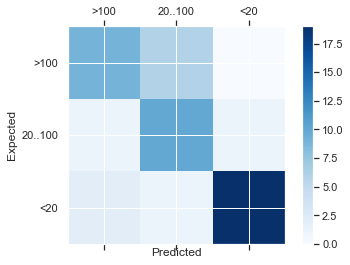

In [533]:
conf_mat = confusion_matrix(y_true=y_test1, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['>100', '20..100', '<20']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [534]:
# grid seacrh
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'max_features': [2,5,10,15],
     'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10,],
    'n_estimators': [100, 500]
}
gsearch = GridSearchCV(estimator = RandomForestClassifier(random_state=42), 
            param_grid = param_grid, scoring='f1_weighted',n_jobs=-1,iid=False, cv=5)
gsearch.fit(X,y)
gsearch.best_params_, gsearch.best_score_

({'bootstrap': True,
  'max_depth': 80,
  'max_features': 10,
  'min_samples_leaf': 3,
  'min_samples_split': 8,
  'n_estimators': 100},
 0.8853302035654977)

In [536]:
from sklearn.metrics import f1_score
model1 = RandomForestClassifier(bootstrap=True,max_depth=80,max_features=10,
                 min_samples_leaf=3,min_samples_split=10,n_estimators=100,random_state=42).fit(X_train1, y_train1)

print('Accuracy of RandomForest classifier on training set: {:.2f}'
           .format(model1.score(X_train1, y_train1)))
print('Accuracy of RandomForest classifier on test set: {:.2f}'
           .format(model1.score(X_test1, y_test1)))

y_pred = model1.predict(X_test1)
print(classification_report(y_test1, y_pred))
print("f1 score" , f1_score(y_test1, y_pred, average='weighted') )

Accuracy of RandomForest classifier on training set: 1.00
Accuracy of RandomForest classifier on test set: 0.84
              precision    recall  f1-score   support

           0       1.00      0.53      0.70        15
           1       0.60      1.00      0.75        12
           2       1.00      0.95      0.98        22

    accuracy                           0.84        49
   macro avg       0.87      0.83      0.81        49
weighted avg       0.90      0.84      0.84        49

f1 score 0.8351664224840595


Confusion matrix:
 [[ 8  7  0]
 [ 0 12  0]
 [ 0  1 21]]


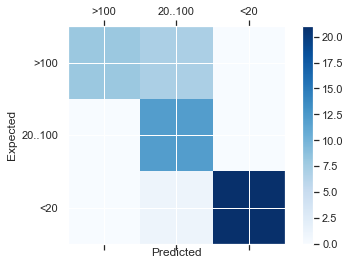

In [537]:
# after optimization
conf_mat = confusion_matrix(y_true=y_test1, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['>100', '20..100', '<20']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [418]:
# from sklearn.model_selection import GridSearchCV
# param_test = {
#  'max_depth':range(3,10,1),
#  'min_child_weight':range(1,6,2),
#   'learning_rate' : np.arange(0,0.1,0.01)  
# }
# gsearch = GridSearchCV(estimator = xgb.XGBClassifier(random_state=42), 
#             param_grid = param_test, scoring='f1_weighted',n_jobs=-1,iid=False, cv=5)
# gsearch.fit(X,y)
# gsearch.best_params_, gsearch.best_score_

In [468]:
# from sklearn.model_selection import GridSearchCV
# param_test = {
#  'n_neighbors':[3,5],
#  'weights':['uniform','distance'],
#  'metric':['euclidean','manhattan']
# }
# gsearch = GridSearchCV(estimator = KNeighborsClassifier(), 
#             param_grid = param_test, scoring='f1_weighted',n_jobs=-1,iid=False, cv=5)
# gsearch.fit(X,y)
# gsearch.best_params_, gsearch.best_score_

In [469]:
# model = XGBClassifier(random_state=42,max_depth=3,min_child_weight=1,learning_rate=0.01)
# model.fit(X_train1, y_train1)
# y_pred = model.predict(X_test1)
# accuracy = accuracy_score(y_test1, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Set the parameters by cross-validation

# tuned_parameters = [{'kernel': ['rbf'],
#                      'C': [1, 10]},
#                     {'kernel': ['linear'], 'C': [1, 10]}]

# gsearch = GridSearchCV(estimator = SVC(random_state=42), 
#             param_grid = tuned_parameters, scoring='f1_weighted',n_jobs=-1,iid=False, cv=5)

# gsearch.fit(X,y)

# gsearch.best_params_, gsearch.best_score_

In [470]:
# model1 = XGBClassifier(random_state=42).fit(X_train1, y_train1,)
    
# print('Accuracy of XGB classifier on training set: {:.2f}'
#            .format(model1.score(X_train1, y_train1)))
# print('Accuracy of XGB classifier on test set: {:.2f}'
#            .format(model1.score(X_test1, y_test1)))

# y_pred = model1.predict(X_test1)
# print(classification_report(y_test1, y_pred))

In [353]:
# lets try SMOTE

In [476]:
# smote=SMOTE('minority')

# xsm1,ysm1=smote.fit_sample(X_train1,y_train1)
# xsm1,ysm1=smote.fit_sample(xsm1,ysm1)
# print(xsm1.shape,ysm1.shape)

In [477]:
# plt.hist(ysm1, bins=5)
# plt.ylabel('Customer Count')
# plt.show()

In [478]:
# X_test1=X_test1.as_matrix()
# y_test1=y_test1.as_matrix()

In [479]:
# #create an array of models
# models = []
# models.append(("LR",LogisticRegression(random_state=42)))
# models.append(("NB",GaussianNB()))
# models.append(("RF",RandomForestClassifier(random_state=42)))
# models.append(("SVC",SVC(random_state=42)))
# models.append(("Dtree",DecisionTreeClassifier(random_state=42)))
# models.append(("XGB",xgb.XGBClassifier(random_state=42)))
# models.append(("KNN",KNeighborsClassifier()))

# #measure the accuracy 
# for name,model in models:
#     kfold = KFold(n_splits=3, random_state=42)
#     cv_result = cross_val_score(model,xsm1,ysm1, cv = kfold,scoring = "accuracy")
#     print(name, cv_result)

In [480]:
# model = XGBClassifier(random_state=42)
# model.fit(xsm1, ysm1)
# y_pred = model.predict(X_test1)
# accuracy = accuracy_score(y_test1, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [483]:
# print(classification_report(y_test1, y_pred))

In [484]:
# from sklearn.metrics import f1_score
# model1 = RandomForestClassifier(bootstrap=True,max_depth=80,max_features=10,
#                  min_samples_leaf=3,min_samples_split=10,n_estimators=100,random_state=42).fit(xsm1, ysm1)

# print('Accuracy of XGB classifier on training set: {:.2f}'
#            .format(model1.score(xsm1, ysm1)))
# print('Accuracy of XGB classifier on test set: {:.2f}'
#            .format(model1.score(X_test1, y_test1)))

# y_pred = model1.predict(X_test1)
# print(classification_report(y_test1, y_pred))
# print("f1 score" , f1_score(y_test1, y_pred, average='weighted') )

In [485]:
### Churn

In [486]:
#converting the type of Invoice Date Field from string to datetime.
# sales=sales_copy
sales['Date'] = pd.to_datetime(sales['Date'])

cust_group = sales.groupby(['CustId','Date'])['SellPrice'].sum().reset_index()

In [487]:
list(sales.columns) 

['Date',
 'OrderNumber',
 'OrderLineNumber',
 'Quantity',
 'SellPrice',
 'CCN',
 'PartnerNumber',
 'Material',
 'ItemCategoryGroup',
 'ItemCategory',
 'ItemDescription',
 'ProductCode',
 'ProductDescription',
 'NounCodeDescription',
 'NounCode',
 'ShipFrom',
 'CustomerName',
 'CustId',
 'City',
 'State',
 'PostalCode',
 'Country',
 'Region',
 'SubRegion',
 'Industry',
 'IndustryGroup',
 'Plant',
 'PlantType',
 'PlantPlatform',
 'Market',
 'InvoiceYearMonth',
 'Revenue',
 'MinPurchaseDate',
 'MinPurchaseYearMonth',
 'UserType']

In [488]:
# calcualte frequency
frequency = cust_group.groupby('CustId').Date.count().reset_index()
frequency.columns = ['CustId','frequency']


In [489]:
#claculate period max -min
max_purchase = cust_group.groupby('CustId').Date.max().reset_index()
min_purchase = cust_group.groupby('CustId').Date.min().reset_index()
max_purchase.columns = ['CustId','max_purchase']
min_purchase.columns = ['CustId','min_purchase']

In [490]:
len(frequency)

230

In [491]:
fs = pd.merge(frequency,min_purchase,on='CustId',how='left')
fs = pd.merge(fs,max_purchase,on='CustId',how='left')
fs['Period'] = ((fs['max_purchase'] - fs['min_purchase']).dt.days)
fs.head()

CustId  frequency min_purchase max_purchase  Period
0       8          3   2019-03-15   2019-03-27      12
1      74          1   2017-07-21   2017-07-21       0
2      85          1   2014-06-04   2014-06-04       0
3      88          2   2017-03-01   2017-04-27      57
4     120          3   2014-10-04   2018-04-18    1292

In [492]:
# remove one time purchaces
fs=fs.loc[fs['frequency'] > 1]

In [493]:
#daily rate
fs['rate'] = fs['frequency']/fs['Period']
fs.loc[~np.isfinite(fs['rate']), 'rate'] = np.nan
fs.head()

CustId  frequency min_purchase max_purchase  Period      rate
0       8          3   2019-03-15   2019-03-27      12  0.250000
3      88          2   2017-03-01   2017-04-27      57  0.035088
4     120          3   2014-10-04   2018-04-18    1292  0.002322
5     125          2   2014-08-28   2014-10-03      36  0.055556
6     129          4   2018-09-05   2019-02-06     154  0.025974

In [494]:
fs.describe()

CustId    frequency       Period        rate
count   177.000000   177.000000   177.000000  177.000000
mean   2100.706215   140.864407  1077.033898    0.110276
std    1260.018932   247.186840   738.515733    0.140963
min       8.000000     2.000000     4.000000    0.001323
25%     988.000000     4.000000   350.000000    0.010799
50%    2082.000000    17.000000  1125.000000    0.046218
75%    3071.000000   138.000000  1905.000000    0.170256
max    4310.000000  1182.000000  1951.000000    0.605843

In [495]:
# use mean as a criteria for "death" or "live" customer

ave=fs["rate"].mean()
print(ave)
fs['observed'] = np.where(fs['rate']>=ave, '0', '1')
#fs['observed'] = np.where(fs['Period']<=30, '0', '1')
fs['observed']=pd.to_numeric(fs.observed)
# 0 no death yet, higher rate good

0.11027619784400679


In [496]:
fs.dtypes

CustId                   int64
frequency                int64
min_purchase    datetime64[ns]
max_purchase    datetime64[ns]
Period                   int64
rate                   float64
observed                 int64
dtype: object

In [497]:
df=fs[['CustId', 'observed' , 'Period']]
df.head()

CustId  observed  Period
0       8         0      12
3      88         1      57
4     120         1    1292
5     125         1      36
6     129         1     154

In [498]:
df.shape

(177, 3)

In [499]:
# #merge first purchase date column to our main dataframe

# #Don't think we need to merge with original data set

sales_copy1 = pd.merge(sales, df, on='CustId')
sales_copy1.head()

Date          OrderNumber  OrderLineNumber  Quantity   SellPrice  \
0 2014-01-02  order_number_194969               80         1  1009.33081   
1 2014-01-02  order_number_105429              180         1    55.99986   
2 2014-01-02  order_number_105429              180         1  1847.99538   
3 2014-01-02  order_number_105429              180         1   459.99885   
4 2014-01-02  order_number_105429              180         1    33.33325   

         CCN         PartnerNumber  Material ItemCategoryGroup ItemCategory  \
0   ccn_3895  partner_number_98261  mat_3374    item_cat_grp_1   item_cat_8   
1  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
2  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
3  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   
4  ccn_19277  partner_number_82869  mat_3519    item_cat_grp_0   item_cat_1   

   ...   PlantType     PlantPlatform            Market InvoiceYearMonth  \
0  ...  Unassigned  plant_platform_1  General Industry           201401   
1  ...  Unassigned  plant_platform_1  General Industry           201401   
2  ...  Unassigned  plant_platform_1  General Industry           201401   
3  ...  Unassigned  plant_platform_1  General Industry           201401   
4  ...  Unassigned  plant_platform_1  General Industry           201401   

      Revenue MinPurchaseDate MinPurchaseYearMonth  UserType observed Period  
0  1009.33081      2014-01-02               201401       New        0   1601  
1    55.99986      2014-01-02               201401       New        0   1601  
2  1847.99538      2014-01-02               201401       New        0   1601  
3   459.99885      2014-01-02               201401       New        0   1601  
4    33.33325      2014-01-02               201401       New        0   1601  

[5 rows x 37 columns]

In [500]:
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
kmf=KaplanMeierFitter()
fs.head()

CustId  frequency min_purchase max_purchase  Period      rate  observed
0       8          3   2019-03-15   2019-03-27      12  0.250000         0
3      88          2   2017-03-01   2017-04-27      57  0.035088         1
4     120          3   2014-10-04   2018-04-18    1292  0.002322         1
5     125          2   2014-08-28   2014-10-03      36  0.055556         1
6     129          4   2018-09-05   2019-02-06     154  0.025974         1

In [501]:
T=fs["Period"]
C=fs["observed"]

In [502]:
# kmf.fit(T,C)
# %pylab inline
# figsize(12,6)
# #kmf.plot
# kmf.survival_function_.plot()

In [503]:
# naf=NelsonAalenFitter()
# naf.fit((T,C)
# naf.plot()
#         naf.survival_function_.plot()

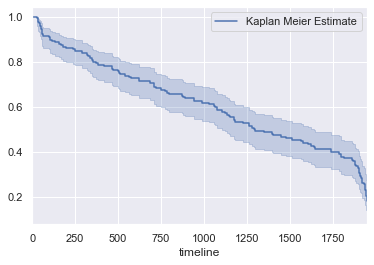

In [504]:
## Example Data 
durations = fs["Period"]
event_observed = fs["observed"]

## create a kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
kmf.plot(ci_show=True) ## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

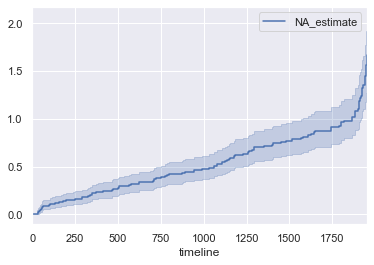

In [505]:
from lifelines import NelsonAalenFitter
naf=NelsonAalenFitter()
naf.fit(durations, event_observed)
naf.plot(ci_show=True)

In [506]:
# fs_types = fs['CustId'].unique()
# len(fs_types)

In [507]:
# #calculate revenue and create a new dataframe for it from modeling years 2017-2019
# sales_copy=sales
# sales_copy['Revenue'] = sales_copy['SellPrice'] * sales_copy['Quantity']
# fs_cust1 = sales_copy.groupby('CustId')['Revenue'].sum().reset_index()
# fs_cust1.columns = ['CustId','Revenue']
# fs_cust1.head(5)
# fs = pd.merge(fs, fs_cust1, on='CustId')
# fs.head()

In [508]:
# # # lets use without 576
# # #fs_cust=fs_cust_test

# # #calcuate revenue score
# # fs_calc['Revenue'] = fs_calc['SellPrice'] * fs_calc['Quantity']
# # fs_revenue = fs_calc.groupby('CustId').Revenue.sum().reset_index()
# # fs_cust = pd.merge(fs_cust, fs_revenue, on='CustId')
# kmeans = KMeans(3)
# kmeans.fit(fs[['Revenue']])
# fs['RevenueCluster'] = kmeans.predict(fs[['Revenue']])
# fs = order_cluster('RevenueCluster', 'Revenue',fs,True)
# fs

In [509]:
# fs['Segment'] = 'Low-Value'
# fs.loc[fs['RevenueCluster']==1,'Segment'] = 'Mid-Value' 
# fs.loc[fs['RevenueCluster']==2,'Segment'] = 'High-Value' 

# # fs=fs.drop(['Revenue'], axis=1)
# # fs=fs.drop(['RevenueCluster'], axis=1)

In [510]:
# fs.groupby('Segment')['Segment'].describe()

In [511]:
# ii=0
# #ax=subplot(111)
# plt.figure(figsize=(15,40))
# #fig, ax = plt.subplots(2, 2)
# for i in fs['Segment'].unique():
#     ax = plt.subplot(10, 3, ii + 1)
#     jj=fs['Segment']==i
#     temp=fs[jj]

#     kmf.fit(temp["Period"],temp["observed"],label=i)
#     ax=kmf.plot(ci_show=True,ax=ax)
#     #ax=kmf.survival_function_.plot(ax=ax)
#     ii=ii+1
#     plt.ylim(0, 1);
# #plt.tight_layout() 

In [512]:
fs_cust1 = pd.merge(fs_class, fs, on='CustId')
fs_cust1.head()

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0    1634           1043.0      694               0         12   
1     221            876.0      624               0        100   
2    1737            795.0      207               1         21   
3     646            604.0       31               2        236   
4     542            334.0      307               1       1775   

   FrequencyCluster       Revenue  RevenueCluster  OverallScore  DayDiff  ...  \
0                 0  6.549984e+04               0             0     37.0  ...   
1                 0  1.399717e+05               0             0     70.0  ...   
2                 0  9.103977e+03               0             1     12.0  ...   
3                 0  5.191520e+05               0             2    533.0  ...   
4                 0  1.340777e+06               0             1     73.0  ...   

   Segment_Low-Value  Segment_Mid-Value  NextPurchaseDayRange  PurchaseRange  \
0                  1                  0                     0      >100 days   
1                  1                  0                     0      >100 days   
2                  1                  0                     0      >100 days   
3                  0                  1                     0      >100 days   
4                  1                  0                     0      >100 days   

   frequency  min_purchase  max_purchase  Period      rate  observed  
0          5    2014-09-23    2017-12-14    1178  0.004244         1  
1          9    2014-04-29    2017-09-08    1228  0.007329         1  
2          7    2014-04-28    2018-08-10    1565  0.004473         1  
3         20    2014-02-27    2018-07-26    1610  0.012422         1  
4         55    2014-01-10    2017-11-14    1404  0.039174         1  

[5 rows x 25 columns]

In [513]:
fs_cust1.groupby('NextPurchaseDayRange')['NextPurchaseDayRange'].describe()

count  mean  std  min  25%  50%  75%  max
NextPurchaseDayRange                                           
0                      21.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1                      21.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
2                      39.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0

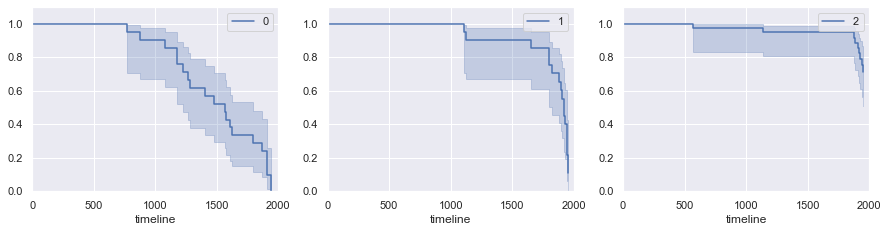

In [514]:
ii=0
#ax=subplot(111)
plt.figure(figsize=(15,40))
#fig, ax = plt.subplots(2, 2)
for i in fs_cust1['NextPurchaseDayRange'].unique():
    ax = plt.subplot(10, 3, ii + 1)
    jj=fs_cust1['NextPurchaseDayRange']==i
    temp=fs_cust1[jj]

    kmf.fit(temp["Period"],temp["observed"],label=i)
    ax=kmf.plot(ci_show=True,ax=ax)
    #ax=kmf.survival_function_.plot(ax=ax)
    ii=ii+1
    plt.ylim(0, 1.1);
    plt.xlim(0, 2000);    
#plt.tight_layout() 

# fs_class['NextPurchaseDayRange'] = 2
# fs_class.loc[fs_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 1
# fs_class.loc[fs_class.NextPurchaseDay>200,'NextPurchaseDayRange'] = 0
#timeline in days

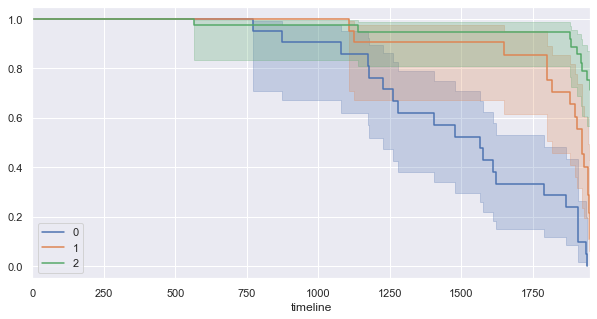

In [515]:

plt.figure(figsize=(10,5))
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in fs_cust1.groupby('NextPurchaseDayRange'):
    kmf.fit(grouped_df["Period"], grouped_df["observed"], label=name)
    kmf.plot(ax=ax)

In [516]:
#overall scoring
fs_cust2=fs_cust1
fs_cust2['Range'] = '<20 days'
fs_cust1.loc[fs_cust1['NextPurchaseDayRange']==1,'Range'] = '[20..100] days' 
fs_cust1.loc[fs_cust1['NextPurchaseDayRange']==2,'Range'] = '>100 days' 
fs_cust1

CustId  NextPurchaseDay  Recency  RecencyCluster  Frequency  \
0     1634           1043.0      694               0         12   
1      221            876.0      624               0        100   
2     1737            795.0      207               1         21   
3      646            604.0       31               2        236   
4      542            334.0      307               1       1775   
..     ...              ...      ...             ...        ...   
76    2980              5.0        1               2       2927   
77    1586              5.0        0               2      13881   
78    3163              4.0        0               2      39220   
79     549              4.0        1               2      20128   
80    1610              4.0        0               2      15504   

    FrequencyCluster       Revenue  RevenueCluster  OverallScore  DayDiff  \
0                  0  6.549984e+04               0             0     37.0   
1                  0  1.399717e+05               0             0     70.0   
2                  0  9.103977e+03               0             1     12.0   
3                  0  5.191520e+05               0             2    533.0   
4                  0  1.340777e+06               0             1     73.0   
..               ...           ...             ...           ...      ...   
76                 0  3.945222e+06               0             2      1.0   
77                 1  6.486532e+06               0             3     15.0   
78                 1  3.028976e+07               1             4      2.0   
79                 1  1.819181e+07               1             4      1.0   
80                 1  1.119850e+07               0             3      1.0   

    ...  Segment_Mid-Value  NextPurchaseDayRange  PurchaseRange  frequency  \
0   ...                  0                     0      >100 days          5   
1   ...                  0                     0      >100 days          9   
2   ...                  0                     0      >100 days          7   
3   ...                  1                     0      >100 days         20   
4   ...                  0                     0      >100 days         55   
..  ...                ...                   ...            ...        ...   
76  ...                  1                     2       <20 days        162   
77  ...                  1                     2       <20 days        418   
78  ...                  0                     2       <20 days        817   
79  ...                  0                     2       <20 days        879   
80  ...                  1                     2       <20 days        715   

    min_purchase  max_purchase  Period      rate observed      Range  
0     2014-09-23    2017-12-14    1178  0.004244        1   <20 days  
1     2014-04-29    2017-09-08    1228  0.007329        1   <20 days  
2     2014-04-28    2018-08-10    1565  0.004473        1   <20 days  
3     2014-02-27    2018-07-26    1610  0.012422        1   <20 days  
4     2014-01-10    2017-11-14    1404  0.039174        1   <20 days  
..           ...           ...     ...       ...      ...        ...  
76    2014-01-21    2019-03-15    1879  0.086216        1  >100 days  
77    2014-01-03    2019-05-07    1950  0.214359        0  >100 days  
78    2014-01-03    2019-05-07    1950  0.418974        0  >100 days  
79    2014-01-03    2019-05-07    1950  0.450769        0  >100 days  
80    2014-01-07    2019-05-07    1946  0.367420        0  >100 days  

[81 rows x 26 columns]

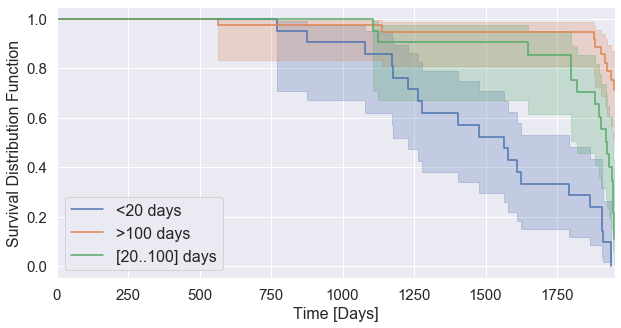

In [517]:
plt.figure(figsize=(10,5))

ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in fs_cust1.groupby('Range'):
    kmf.fit(grouped_df["Period"], grouped_df["observed"], label=name)
    kmf.plot(ax=ax)
    plt.ylabel('Survival Distribution Function', fontsize=16)
    plt.xlabel('Time [Days]', fontsize=16)
    #plt.title("Survival Chart", fontsize=20)
    plt.legend( prop={'size': 16})
    plt.xticks( fontsize = 15)
    plt.yticks( fontsize = 15)    

Nelson Aalen Fitter
Like the Kaplan-Meier Fitter, Nelson Aalen Fitter also gives us an average view of the population[7]. It is given by the number of deaths at time t divided by the number of subjects at risk. It is a non-parametric model. This means that there isn’t a functional form with parameters that we are fitting the data to. It doesn’t have any parameters to fit[7].

Here, ni represents the number of subjects at risk prior to time t. di represents the number of the event of interest at time t.

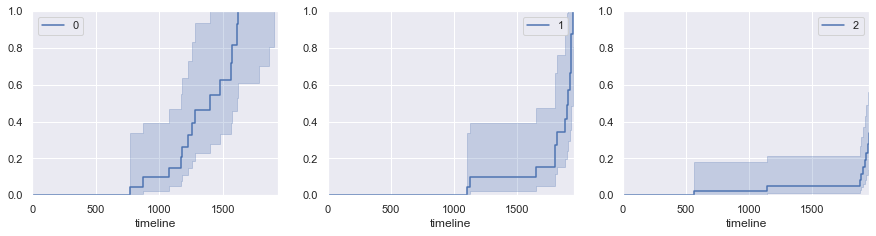

In [518]:
ii=0
#ax=subplot(111)
plt.figure(figsize=(15,40))
#fig, ax = plt.subplots(2, 2)
for i in fs_cust1['NextPurchaseDayRange'].unique():
    ax = plt.subplot(10, 3, ii + 1)
    jj=fs_cust1['NextPurchaseDayRange']==i
    temp=fs_cust1[jj]

    naf.fit(temp["Period"],temp["observed"],label=i)
    ax=naf.plot(ci_show=True,ax=ax)
    #ax=kmf.survival_function_.plot(ax=ax)
    ii=ii+1
    plt.ylim(0, 1);

In [519]:
# list(sales_copy1.columns)

In [520]:
# fs_cust2 = pd.merge(fs_class_revenue, fs, on='CustId')
# fs_cust2.head()

In [521]:
# fs_cust2.groupby('LTVCluster')['LTVCluster'].describe()

In [522]:
# fs_cust2.groupby('LTVCluster')['LTVCluster'].describe()

In [523]:
# ii=0
# #ax=subplot(111)
# plt.figure(figsize=(15,40))
# #fig, ax = plt.subplots(2, 2)
# for i in fs_cust2['LTVCluster'].unique():
#     ax = plt.subplot(10, 3, ii + 1)
#     jj=fs_cust2['LTVCluster']==i
#     temp1=fs_cust2[jj]

#     kmf.fit(temp1["Period"],temp1["observed"],label=i)
#     ax=kmf.plot(ci_show=True,ax=ax)
#     #ax=kmf.survival_function_.plot(ax=ax)
#     ii=ii+1
#     plt.ylim(0, 1.1);
#     plt.xlim(0, 2000);    
# #plt.tight_layout() 

# # fs_class['NextPurchaseDayRange'] = 2
# # fs_class.loc[fs_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 1
# # fs_class.loc[fs_class.NextPurchaseDay>200,'NextPurchaseDayRange'] = 0
# #timeline in days

In [194]:
# 0 - Low revenue
# 1 - Medium reveneu
# 2 - high reveneu

In [200]:
#from lifelines import CoxPHFitter

In [531]:
# sales_copy2= sales_copy1[[  'observed', 'Period','State']]
# sales_copy2
# #sales_copy2['Date'] = pd.to_datetime(sales_copy2['Date'])

In [530]:
# from lifelines.utils import datetimes_to_durations

# # start_times is a vector or list of datetime objects or datetime strings
# # end_times is a vector or list of (possibly missing) datetime objects or datetime strings
# T, E = datetimes_to_durations(start_times, end_times, freq='h')

In [ ]:
# from lifelines.utils import survival_table_from_events

# table = survival_table_from_events(T, C)
# print(table.head())

In [524]:
# from lifelines.datasets import load_regression_dataset
# regression_dataset = load_regression_dataset()

# regression_dataset.head()

In [525]:
## Create dummy variables
# df_dummy = pd.get_dummies(sales_copy2, drop_first=True)
# df_dummy.tail()

In [526]:
# df_dummy['observed'].unique

In [ ]:
## Create dummy variables
# df_dummy = pd.get_dummies(df_r, drop_first=True)
# df_dummy.head()

In [527]:
# list(df_dummy.columns)
# df_dummy['Date'] = df_dummy['Date'].values.astype(float)
# df_dummy

In [528]:
#Using Cox Proportional Hazards model
# cph = CoxPHFitter()   ## Instantiate the class to create a cph object
# cph.fit(df_dummy, 'Period', event_col='observed')   ## Fit the data to train the model
# cph.print_summary()    ## HAve a look at the significance of the features

In [529]:
# cph.plot()